<a href="https://colab.research.google.com/github/PPancham/PhD/blob/main/Scikit_Machine_Learning_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1>Scikit Supervised Machine Learning Analysis</h1>

This is a program written in the Python programming language
which utilizes machine learning to process and classify ELISA data

This program is governed by MIT Liscence

Written in February, 2025 by Pranav Pancham and Tariq Tayebi


In [1]:
# Imports and package install
!pip install Boruta
import joblib
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from collections import defaultdict
from boruta import BorutaPy
from sklearn.linear_model import ElasticNet
from google.colab import files
from sklearn.model_selection import cross_val_score
from logging import Filter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.3 MB/s eta 0:00:00


Best one



**Data Input, Preprocessing of Data within 25% to 75% quantile and Model creation.**

---

It begins by loading data and preprocessing it through outlier removal using the IQR method. An initial model is trained and evaluated, followed by multiple train-test iterations to assess model stability across different data splits. The best-performing model from these iterations is identified based on accuracy scores. Feature importance analysis is then conducted to understand which immunoglobulin markers contribute most significantly to classification. Cross-validation is performed to obtain a more robust performance estimate. Finally, extensive hyperparameter tuning is implemented using GridSearchCV to optimize model parameters such as n_estimators, max_depth, min_samples_split, and min_samples_leaf. The workflow saves three distinct models: the initial model, the best model from multiple evaluations, and the hyperparameter-optimized model, allowing for performance comparison.







In [ ]:
uploadedSpreadsheet = files.upload()
fileName = list(uploadedSpreadsheet.keys())[0]
data = pd.read_excel(fileName)

columns_to_process = ['IgG1 Average', 'IgG2 Average', 'IgG3 Average', 'IgG4 Average', 'IgA Average','IgE Average','IgM Average']#,
                     # 'IgG1 Average_IgG2 Average', 'IgG1 Average_IgG3 Average', 'IgG1 Average_IgG4 Average',
                     # 'IgG1 Average_IgA Average', 'IgG1 Average_IgE Average', 'IgG1 Average_IgM Average',
                      #'IgG2 Average_IgG1 Average', 'IgG2 Average_IgG3 Average', 'IgG2 Average_IgG4 Average',
                      #'IgG2 Average_IgA Average', 'IgG2 Average_IgE Average', 'IgG2 Average_IgM Average',
                     # 'IgG3 Average_IgG1 Average', 'IgG3 Average_IgG2 Average', 'IgG3 Average_IgG4 Average',
                     # 'IgG3 Average_IgA Average', 'IgG3 Average_IgE Average', 'IgG3 Average_IgM Average',
                     # 'IgG4 Average_IgG1 Average', 'IgG4 Average_IgG2 Average', 'IgG4 Average_IgG3 Average',
                     # 'IgG4 Average_IgA Average', 'IgG4 Average_IgE Average', 'IgG4 Average_IgM Average',
                     # 'IgA Average_IgG1 Average', 'IgA Average_IgG2 Average', 'IgA Average_IgG3 Average',
                     # 'IgA Average_IgG4 Average', 'IgA Average_IgE Average', 'IgA Average_IgM Average',
                     # 'IgE Average_IgG1 Average', 'IgE Average_IgG2 Average', 'IgE Average_IgG3 Average',
                     # 'IgE Average_IgG4 Average', 'IgE Average_IgA Average', 'IgE Average_IgM Average',
                    #  'IgM Average_IgG1 Average', 'IgM Average_IgG2 Average', 'IgM Average_IgG3 Average',
                    #  'IgM Average_IgG4 Average', 'IgM Average_IgA Average', 'IgM Average_IgE Average']



def OutlierRemoval(data, columns, filter_data = True):
    if filter_data == False:
      print("\n --- Data has outliers and was not filtered ---")
      return data

    else:

      data_filtered = data.copy()

      for column in columns:
          Q1 = data_filtered[column].quantile(0.25)
          Q3 = data_filtered[column].quantile(0.75)
          IQR = Q3 - Q1

          lower_bound = Q1 - 1.5 * IQR
          upper_bound = Q3 + 1.5 * IQR

          data_filtered = data_filtered[(data_filtered[column] >= lower_bound) &
                                        (data_filtered[column] <= upper_bound)]
      return data_filtered

def SaveData(Pumpkin):
    joblib.dump(Pumpkin, f"Trained_Model_Pumpkin{datetime.date.today()}.pkl")

    return f"Data saved to \'Trained_Model_Pumpkin{datetime.date.today()}.pkl\'"

# Remove outliers
filter_data = []
data = OutlierRemoval(data, columns_to_process, filter_data)
data.head()

# Save to Excel file
output_file = "after_outlier.xlsx"
data.to_excel(output_file, index=False)
print(f"Data saved to '{output_file}'")

# Data Input for Model
feature_names = data[columns_to_process]
Group = data['Group']


# Model Creation
X_train, X_test, y_train, y_test = train_test_split(feature_names, Group, test_size=0.3, stratify= Group) # change this
Pumpkin = RandomForestClassifier(n_estimators=100, random_state=100, bootstrap =True) # change this
Pumpkin.fit(X_train, y_train)
y_pred = Pumpkin.predict(X_test)
# print('accuracy_score:', accuracy_score(y_test, y_pred))



# Perform multiple train/test splits and evaluate model on each
train_indexes = []
test_indexes = []
accuracies = []
models = []

print("\n--- Multiple Train-Test Split Evaluation ---")
num_iterations = 10

for i in range(1, num_iterations + 1):
    print(f"\nIteration {i}/{num_iterations}")

    # Split the data into training and testing sets
    # Use stratification based on the 'Group' column
    X_train, X_test, y_train, y_test = train_test_split( feature_names, Group, test_size=0.3, shuffle=True, random_state=i, stratify= Group)

    # Store indexes for potential later use
    train_indexes.append(X_train.index)
    test_indexes.append(X_test.index)

    # Train Random Forest model
    Pumpkin = RandomForestClassifier(
        n_estimators=100,
        random_state=100,
        bootstrap=True
    )
    Pumpkin.fit(X_train, y_train)
    models.append(Pumpkin)

    # Make predictions and evaluate
    y_pred = Pumpkin.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Iteration {i} Accuracy: {accuracy:.4f}')

    # Print summary classification metrics for each iteration
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Weighted F1-score: {report['weighted avg']['f1-score']:.4f}")

# Print overall performance statistics
print("\n--- Overall Performance Statistics ---")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")
print(f"Min Accuracy: {np.min(accuracies):.4f}")
print(f"Max Accuracy: {np.max(accuracies):.4f}")

# Select the best model based on accuracy
best_model_idx = np.argmax(accuracies)
best_model = models[best_model_idx]
print(f"\nBest model from iteration {best_model_idx + 1} with accuracy: {accuracies[best_model_idx]:.4f}")

# Evaluate the best model more thoroughly
best_X_train_idx = train_indexes[best_model_idx]
best_X_test_idx = test_indexes[best_model_idx]
X_test_best = feature_names.loc[best_X_test_idx]
y_test_best = Group.loc[best_X_test_idx]
y_pred_best = best_model.predict(X_test_best)

# Print detailed classification report for the best model
print("\nClassification Report (Best Model):")
print(classification_report(y_test_best, y_pred_best))

# Print confusion matrix for the best model
print("\nConfusion Matrix (Best Model):")
print(confusion_matrix(y_test_best, y_pred_best))

# Feature importance for the best model
feature_importance = pd.DataFrame({
    'Feature': columns_to_process,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Best Model):")
print(feature_importance)

# Save the best trained model
save_result = SaveData(best_model, "Trained_Model__Best_")
print(save_result)

# Implement k-fold cross-validation
cv_scores = cross_val_score(Pumpkin, feature_names, Group, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

# Save the Model
SaveData(Pumpkin)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

# Fit to the data
grid_search.fit(feature_names, Group)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


# Print the best parameters and its accuracy
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get results and sort by mean test score in descending order
results = zip(grid_search.cv_results_['mean_test_score'],
              grid_search.cv_results_['params'])
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)

# Print sorted results
print("Models sorted by descending accuracy:")
for i, (mean_score, params) in enumerate(sorted_results):
    print(f"{i+1}. Accuracy: {mean_score:.4f} with parameters: {params}")


**Model created with outlier removed , no tuning **

In [13]:
uploadedSpreadsheet = files.upload()
fileName = list(uploadedSpreadsheet.keys())[0]
data = pd.read_excel(fileName)

columns_to_process = ['IgG1 Average', 'IgG2 Average', 'IgG3 Average', 'IgG4 Average', 'IgA Average','IgE Average','IgM Average']#,
                     # 'IgG1 Average_IgG2 Average', 'IgG1 Average_IgG3 Average', 'IgG1 Average_IgG4 Average',
                     # 'IgG1 Average_IgA Average', 'IgG1 Average_IgE Average', 'IgG1 Average_IgM Average',
                      #'IgG2 Average_IgG1 Average', 'IgG2 Average_IgG3 Average', 'IgG2 Average_IgG4 Average',
                      #'IgG2 Average_IgA Average', 'IgG2 Average_IgE Average', 'IgG2 Average_IgM Average',
                     # 'IgG3 Average_IgG1 Average', 'IgG3 Average_IgG2 Average', 'IgG3 Average_IgG4 Average',
                     # 'IgG3 Average_IgA Average', 'IgG3 Average_IgE Average', 'IgG3 Average_IgM Average',
                     # 'IgG4 Average_IgG1 Average', 'IgG4 Average_IgG2 Average', 'IgG4 Average_IgG3 Average',
                     # 'IgG4 Average_IgA Average', 'IgG4 Average_IgE Average', 'IgG4 Average_IgM Average',
                     # 'IgA Average_IgG1 Average', 'IgA Average_IgG2 Average', 'IgA Average_IgG3 Average',
                     # 'IgA Average_IgG4 Average', 'IgA Average_IgE Average', 'IgA Average_IgM Average',
                     # 'IgE Average_IgG1 Average', 'IgE Average_IgG2 Average', 'IgE Average_IgG3 Average',
                     # 'IgE Average_IgG4 Average', 'IgE Average_IgA Average', 'IgE Average_IgM Average',
                    #  'IgM Average_IgG1 Average', 'IgM Average_IgG2 Average', 'IgM Average_IgG3 Average',
                    #  'IgM Average_IgG4 Average', 'IgM Average_IgA Average', 'IgM Average_IgE Average']



def OutlierRemoval(data, columns):
    # if filter_data == False:
    #   print("\n --- Data has outliers and was not filtered ---")
    #   return data

    # else:

      data_filtered = data.copy()

      for column in columns:
          Q1 = data_filtered[column].quantile(0.25)
          Q3 = data_filtered[column].quantile(0.75)
          IQR = Q3 - Q1

          lower_bound = Q1 - 1.5 * IQR
          upper_bound = Q3 + 1.5 * IQR

          data_filtered = data_filtered[(data_filtered[column] >= lower_bound) &
                                        (data_filtered[column] <= upper_bound)]
      return data_filtered

def SaveData(Pumpkin):
    joblib.dump(Pumpkin, f"Trained_Model_Pumpkin{datetime.date.today()}.pkl")

    return f"Data saved to \'Trained_Model_Pumpkin{datetime.date.today()}.pkl\'"

# Remove outliers
data = OutlierRemoval(data, columns_to_process)
data.head()

# Save to Excel file
output_file = "after_outlier.xlsx"
data.to_excel(output_file, index=False)
print(f"Data saved to '{output_file}'")

# Data Input for Model
feature_names = data[columns_to_process]
Group = data['Group']


# Model Creation
X_train, X_test, y_train, y_test = train_test_split(feature_names, Group, test_size=0.3, random_state=42, stratify= Group) # change this
Pumpkin = RandomForestClassifier(n_estimators=100, random_state=100, bootstrap =True) # change this
Pumpkin.fit(X_train, y_train)
y_pred = Pumpkin.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))

# Save the Model
SaveData(Pumpkin)

Saving Biomarker_16032025_without_SWD_with_GNV.xlsx to Biomarker_16032025_without_SWD_with_GNV (1).xlsx
Data saved to 'after_outlier.xlsx'
accuracy_score: 0.7922077922077922


"Data saved to 'Trained_Model_Pumpkin2025-03-21.pkl'"

**Model Validation and Scores**


Accuracy: 0.7922


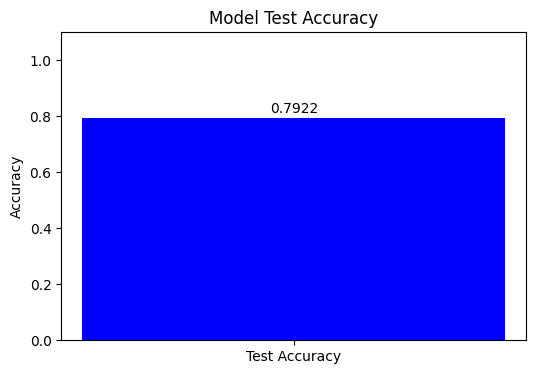


Classification Report:
                     precision    recall  f1-score   support

                AD       0.67      0.46      0.55        13
Cognitive Negative       0.69      0.78      0.73        23
Cognitive Positive       0.89      0.85      0.87        20
               MCI       0.87      0.95      0.91        21

          accuracy                           0.79        77
         macro avg       0.78      0.76      0.77        77
      weighted avg       0.79      0.79      0.79        77



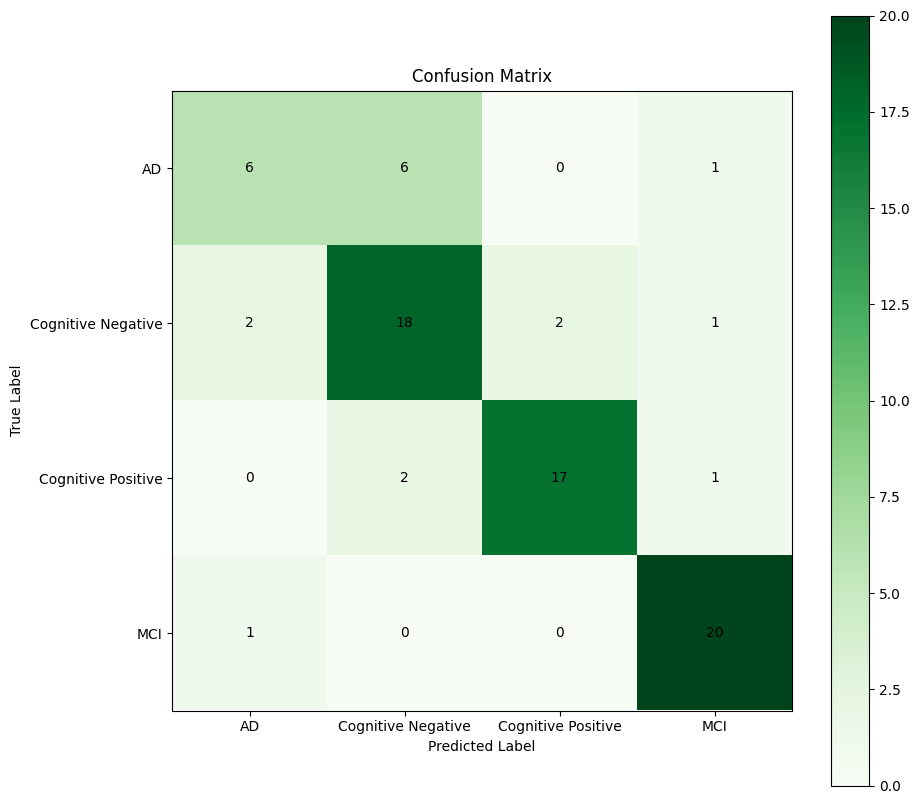

In [3]:
def ConfusionMatrix(y_test, y_pred, cmap, class_names=None):
    conf_matrix = confusion_matrix(y_test, y_pred)

    if class_names is None:
      class_names = sorted(set(y_test))

    plt.figure(figsize=(10, 10))
    plt.imshow(conf_matrix, cmap=cmap, interpolation="nearest")

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.xticks(np.arange(len(class_names)), class_names)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()


def StandardDeviation(data):
    dataSTD = data.std()

    return dataSTD


def TestAccuracy(y_test, y_pred, data):
    testAccuracy = accuracy_score(y_test, y_pred)
    print()
    print(f"Accuracy: {testAccuracy:.4}")
  # print(f"Standard Deviation: {StandardDeviation(y_test)}")

    plt.figure(figsize=(6, 4))
    plt.bar(['Test Accuracy'], [testAccuracy], color='blue')

    plt.ylabel('Accuracy')
    plt.title('Model Test Accuracy')
    plt.text(0, testAccuracy + 0.01, f'{testAccuracy:.4f}', ha='center', va='bottom')

    plt.ylim(0, 1.1)
    plt.show()


TestAccuracy(y_test, y_pred, data)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrix(y_test, y_pred, "Greens")

**Visualize one tree from the Model upto n_estimators trees**

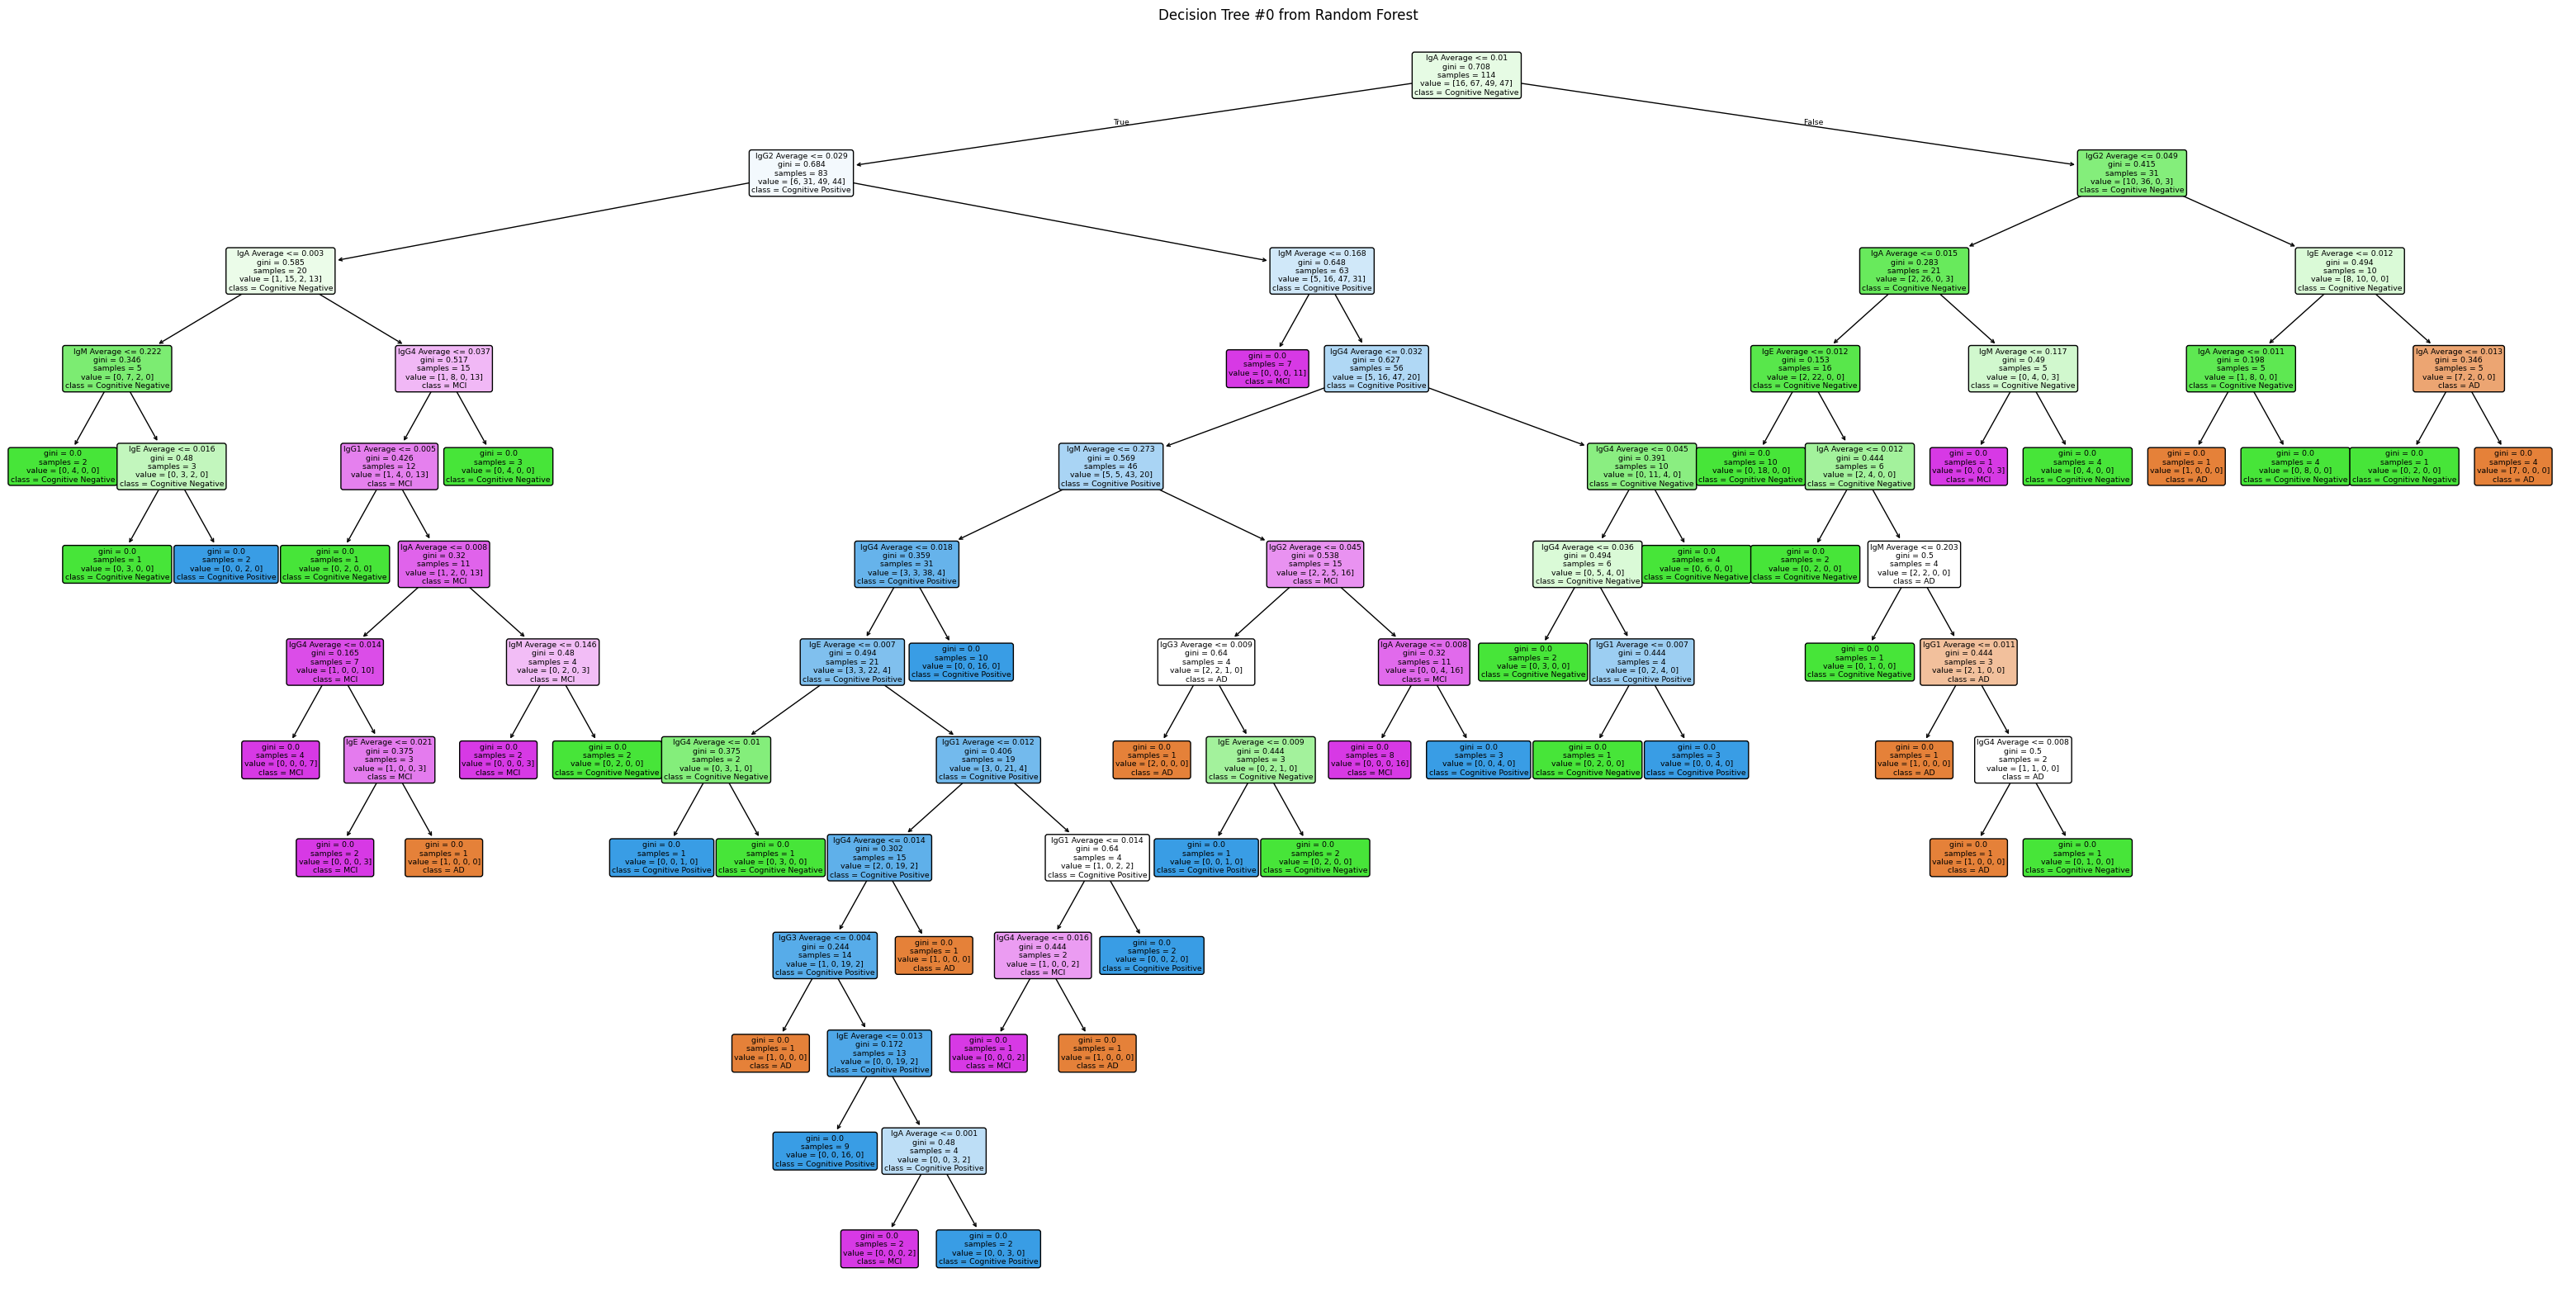

In [4]:
def visualize_decision_tree(Pumpkin, feature_names, tree_idx=0): # Chnage tree_idx for range in 0-99 based on n_estimators
    plt.figure(figsize=(40,20))
    plot_tree(Pumpkin.estimators_[tree_idx],
              feature_names= feature_names.columns.tolist(),
              class_names=list(Pumpkin.classes_),
              filled=True,
              rounded=True)
    plt.title(f"Decision Tree #{tree_idx} from Random Forest")
    plt.show()


visualize_decision_tree(Pumpkin, feature_names)

**Find the feature imporatance for the entire model and feature imporatance by group**




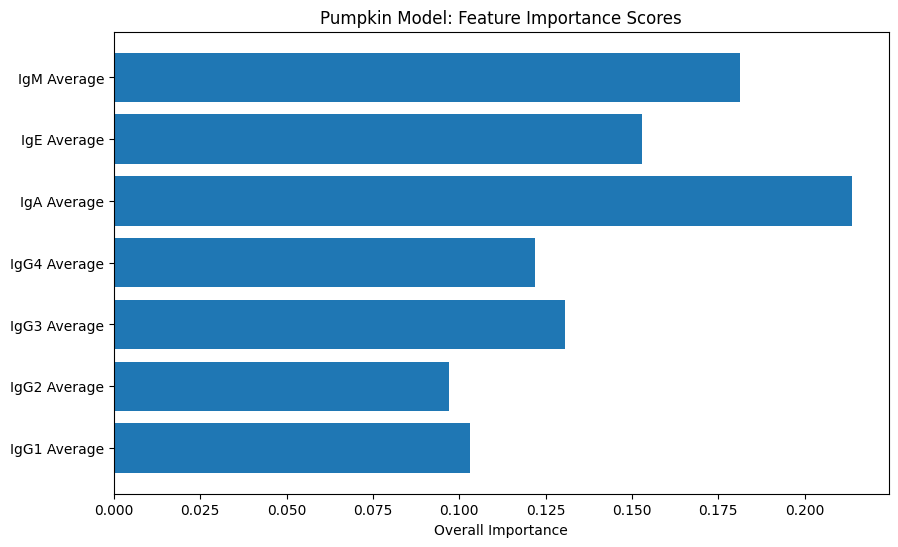

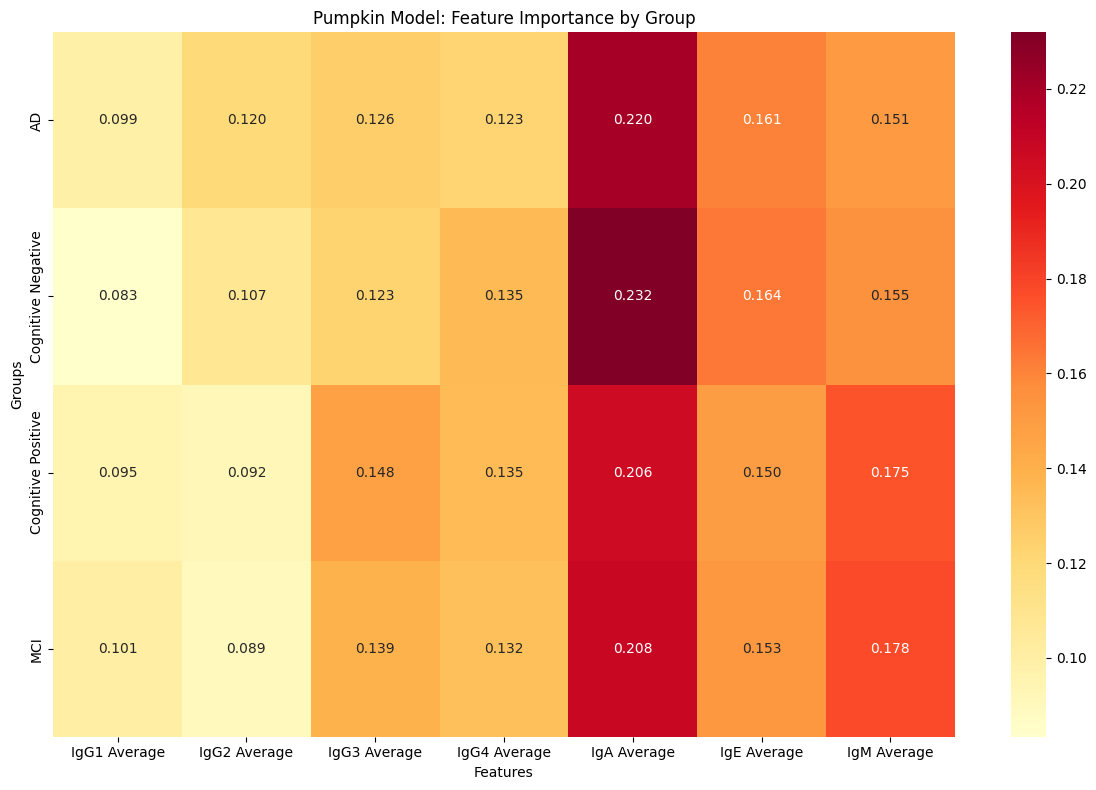

In [5]:
# Calculate feature importance per group
def get_feature_importance_per_group(Pumpkin, feature_names):
    n_classes = len(Pumpkin.classes_)
    n_features = len(feature_names)
    importance_per_group = np.zeros((n_classes, n_features))

    # Calculate importance for each tree
    for tree in Pumpkin.estimators_:
        node_impurity = tree.tree_.impurity
        node_samples = tree.tree_.n_node_samples
        feature = tree.tree_.feature
        value = tree.tree_.value

        # Process each node
        for node in range(tree.tree_.node_count):
            if feature[node] != -2:  # Not a leaf node
                current_sample_dist = value[node][0]

                # Calculate importance for each group
                for group_idx in range(n_classes):
                    group_prop = current_sample_dist[group_idx] / np.sum(current_sample_dist)
                    node_importance = node_impurity[node] * node_samples[node] * group_prop

                    if feature[node] >= 0:
                        importance_per_group[group_idx][feature[node]] += node_importance

    # Normalize importances
    importance_per_group /= len(Pumpkin.estimators_)
    row_sums = importance_per_group.sum(axis=1, keepdims=True)
    importance_per_group = np.divide(importance_per_group, row_sums,
                                   out=np.zeros_like(importance_per_group),
                                   where=row_sums!=0)

    return importance_per_group

# Plot feature importances
def plot_importances(Pumpkin, feature_names):
    # Plot overall feature importance
    plt.figure(figsize=(10, 6))
    importances = Pumpkin.feature_importances_
    # Convert feature_names to list if it's a numpy array
    feature_names_list = list(feature_names)
    # Create range for y-axis positions
    y_pos = np.arange(len(feature_names_list))
    plt.barh(y_pos, importances)
    plt.yticks(y_pos, feature_names_list)
    plt.xlabel("Overall Importance")
    plt.title("Pumpkin Model: Feature Importance Scores")
    plt.show()


    # Plot group-specific importance
    importance_per_group = get_feature_importance_per_group(Pumpkin, feature_names_list)
    importance_df = pd.DataFrame(importance_per_group,
                               columns=feature_names_list,
                               index=Pumpkin.classes_)

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df,
                cmap='YlOrRd',
                annot=True,
                fmt='.3f')
    plt.title('Pumpkin Model: Feature Importance by Group')
    plt.xlabel('Features')
    plt.ylabel('Groups')
    plt.tight_layout()
    plt.show()


    return importance_df


# Plot importances
importance_df = plot_importances(Pumpkin, feature_names)
# print("\nFeature Importance by Group:")
# print(importance_df)


**BorutaPy and Elsatic Net feature selection**


In [20]:
feat_selector = BorutaPy(
    Pumpkin,
    n_estimators='auto',  # Automatically selects number of estimators
    verbose=2,            # Verbosity level (0-2)
    random_state=42,      # For reproducibility
    max_iter=100          # Maximum number of iterations
)

x = feature_names.values
y = Group.values
z = feature_names.columns

# Fit Boruta (note: Boruta needs numpy arrays, not pandas DataFrames)
feat_selector.fit(x, y)

# Get the selected features
selected_features = z[feat_selector.support_]
print("Selected features:", selected_features)

# Get the feature rankings (1 = selected, 2 = tentative, 3+ = rejected)
print("Feature ranking:", feat_selector.ranking_)

# If you want to transform your data to keep only selected features
X_filtered = feat_selector.transform(x)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	0
Selected features: Index(['IgG1 Average', 'IgG2 Average', 'IgG3 Average', 'IgG4 Average',
       'IgA Average', 'IgE Average', 'IgM Average'],
      dtype='object')
Feature ranking: [1 1 1 1 1 1 1]


**Feature Importance by Group and feature within a group - Ratio**

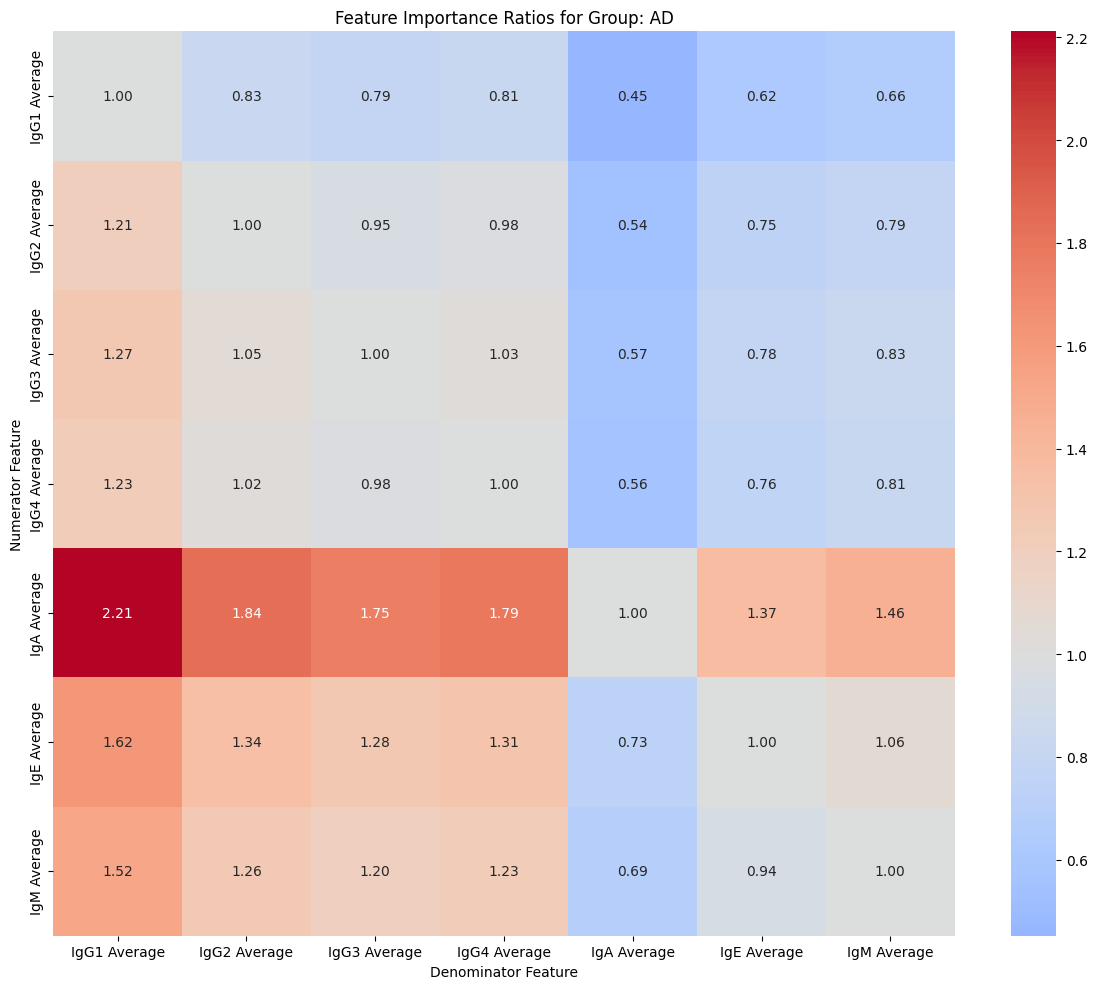

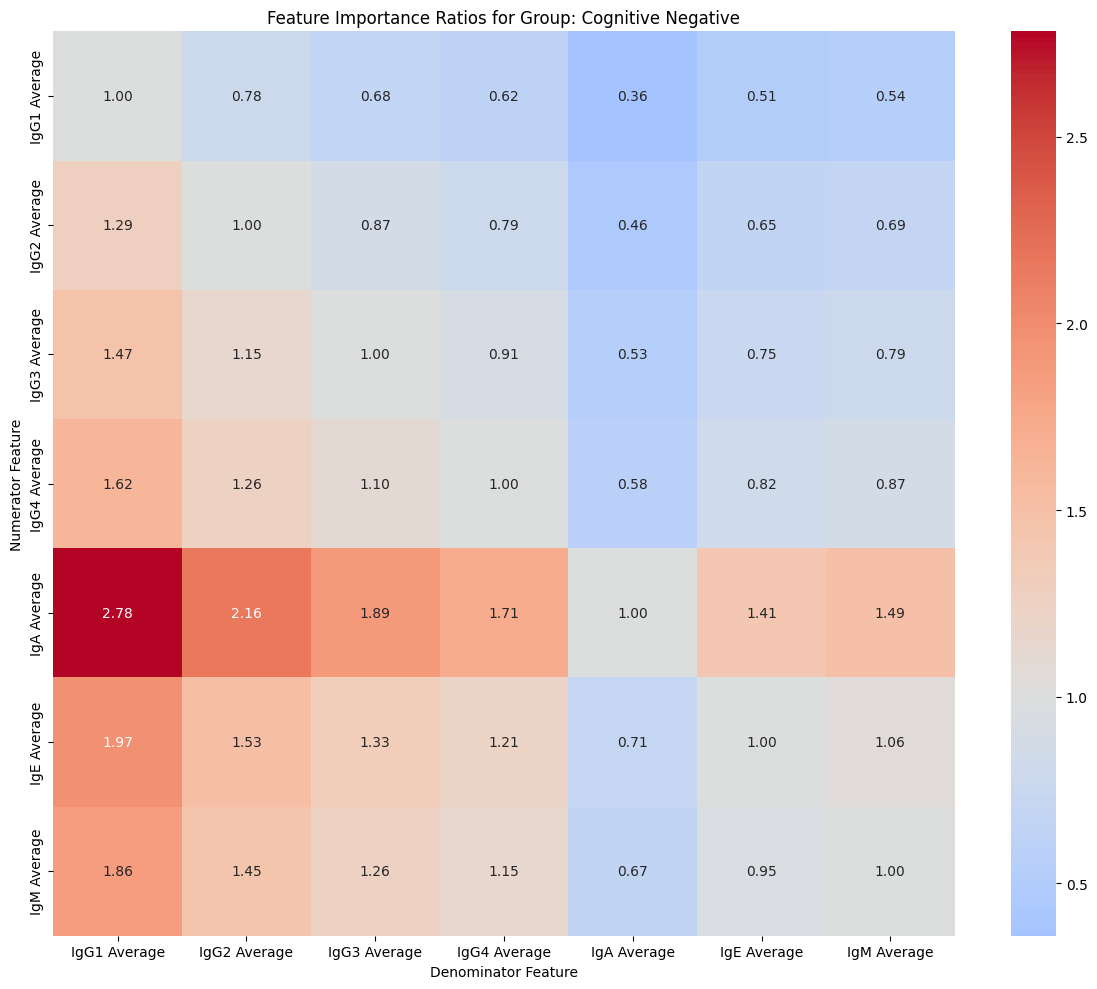

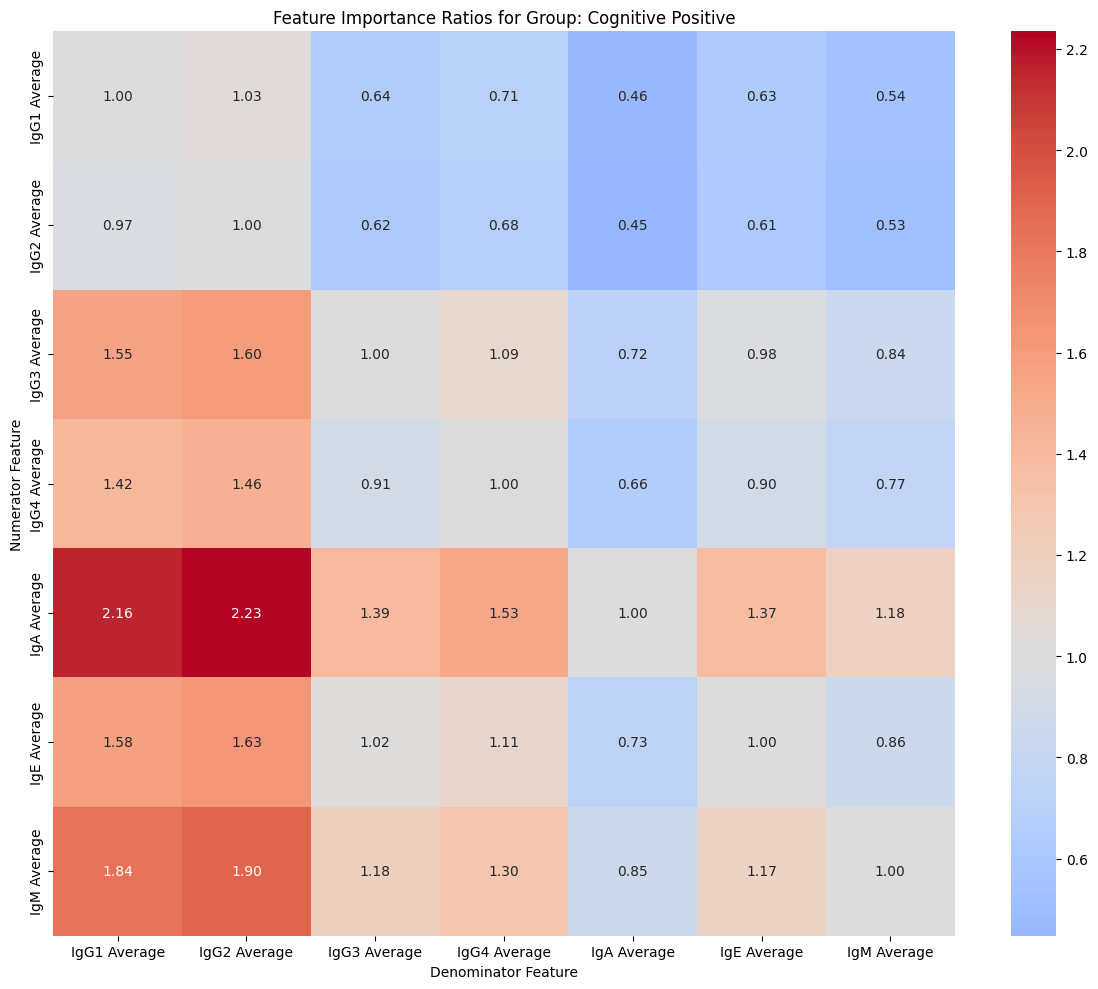

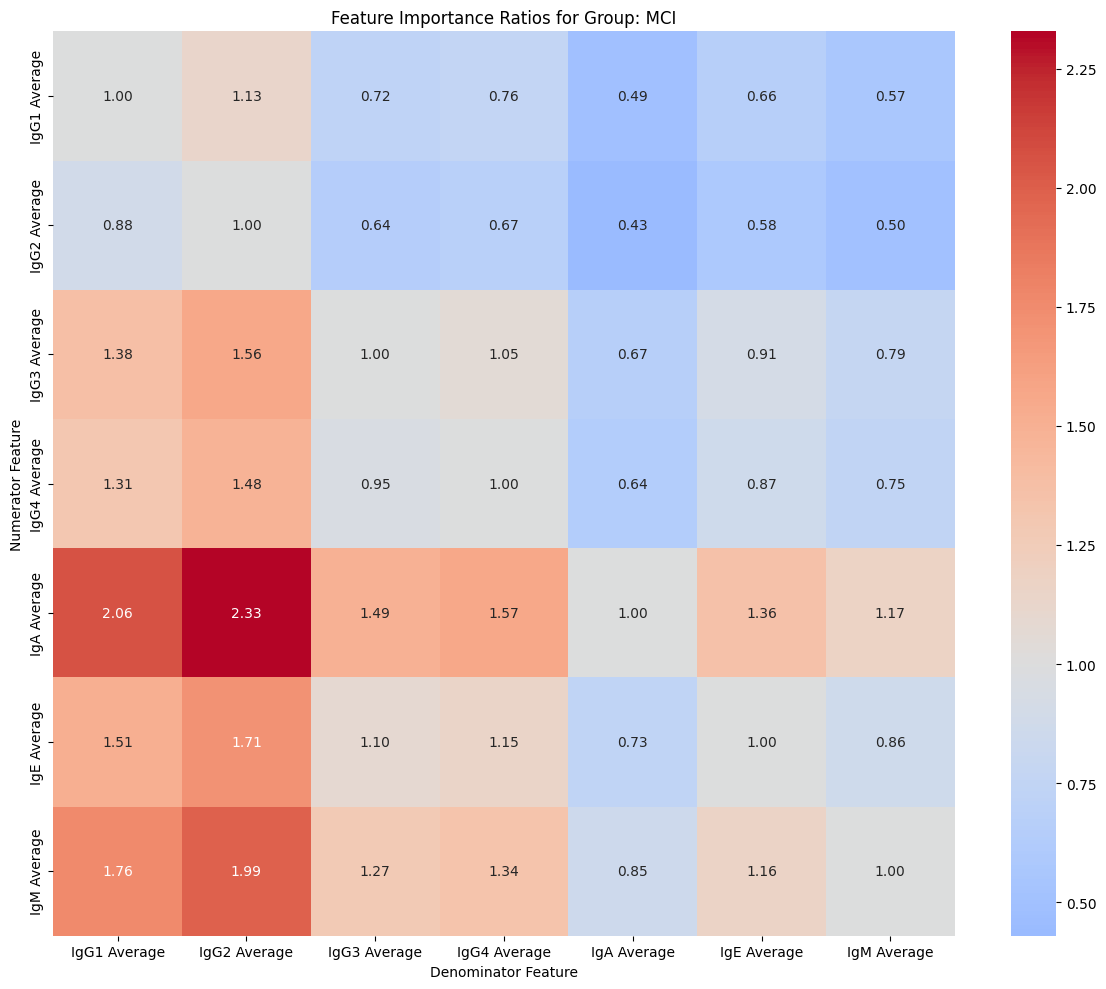

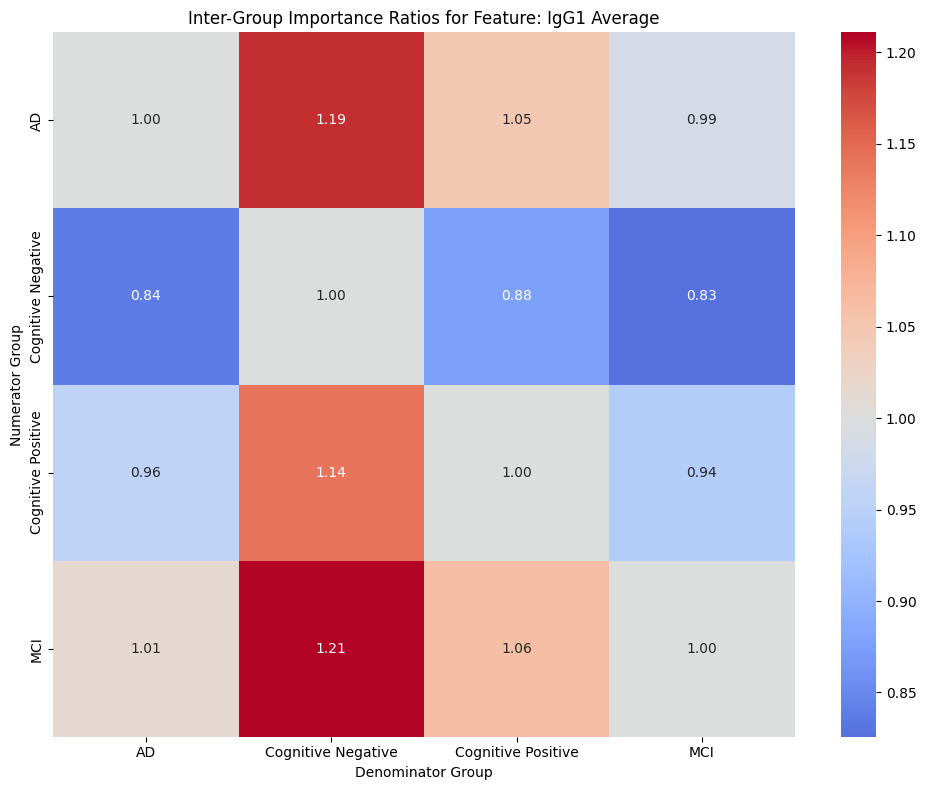

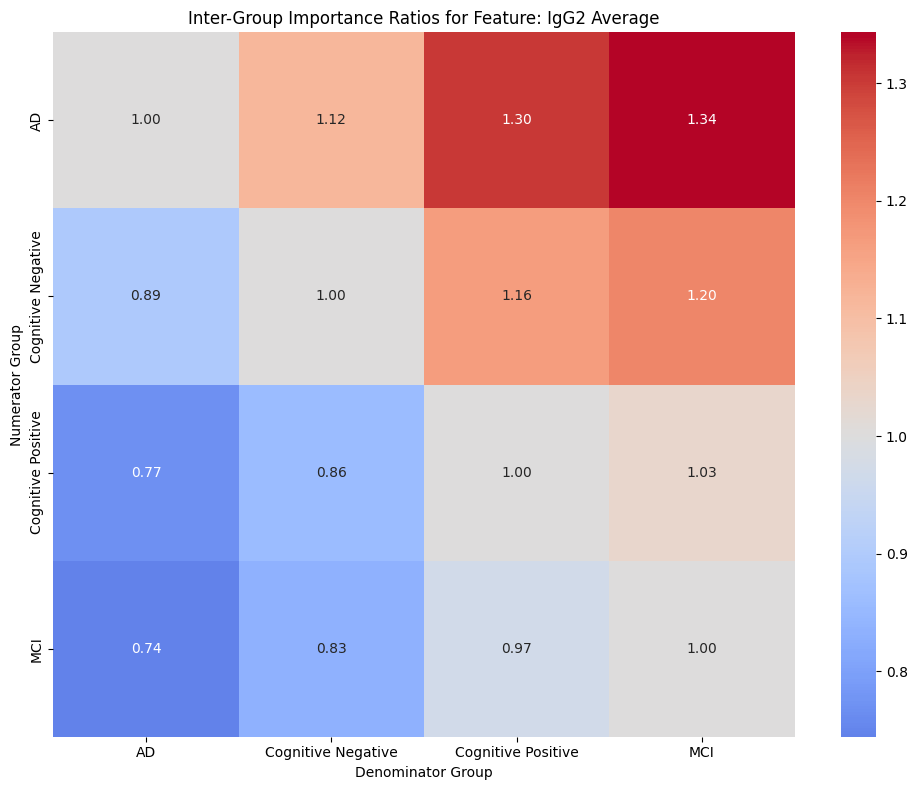

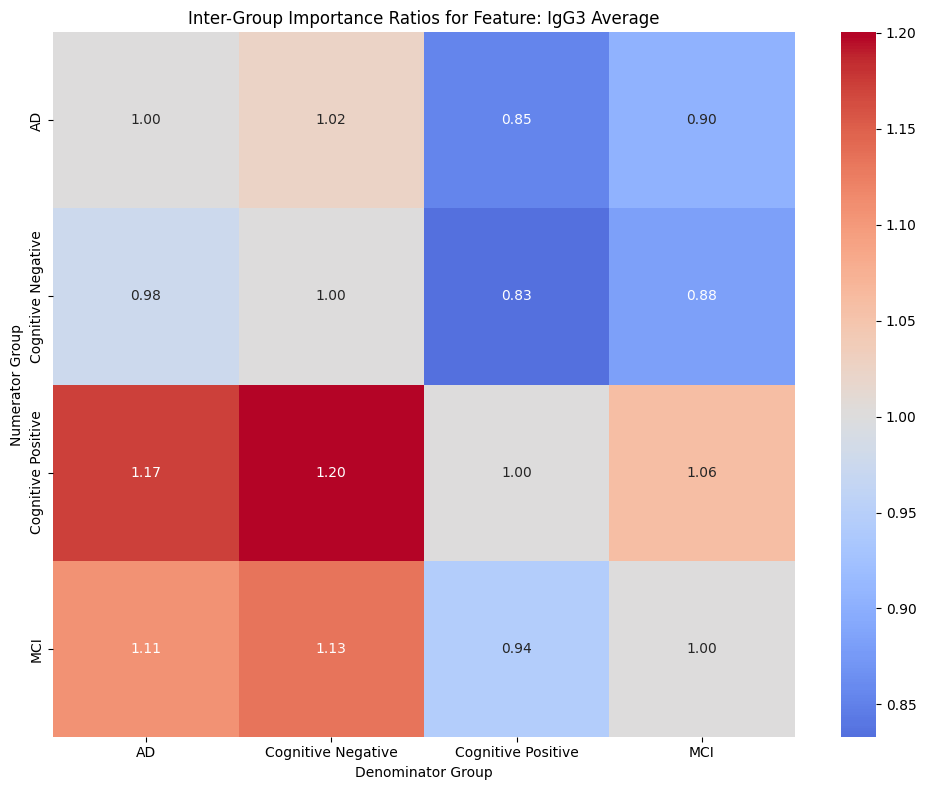

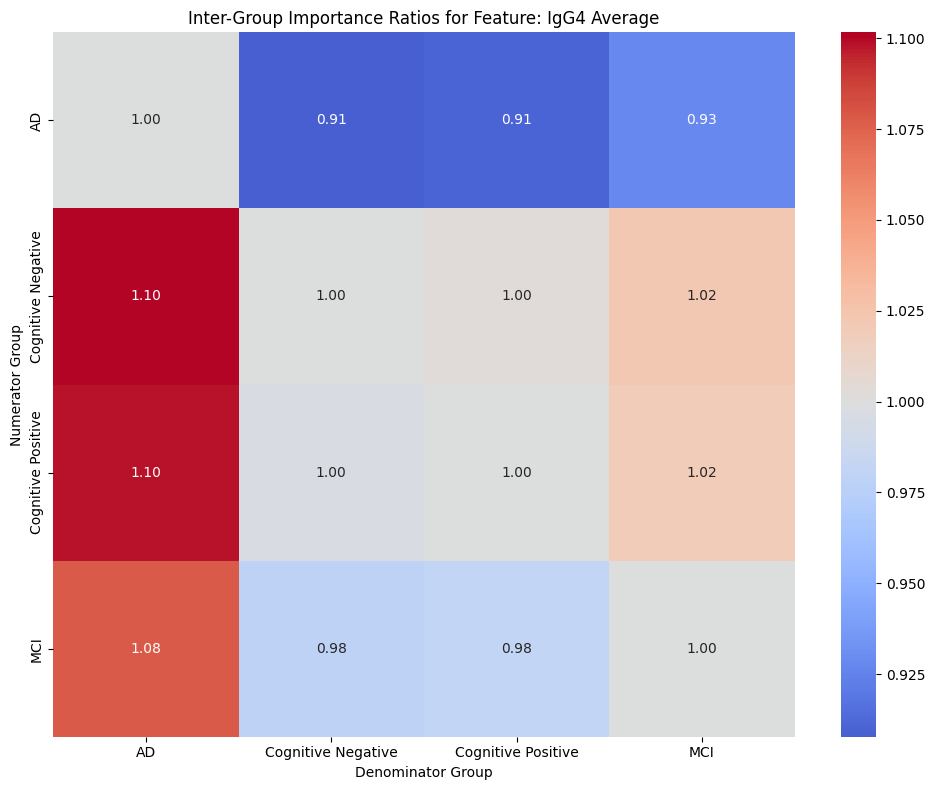

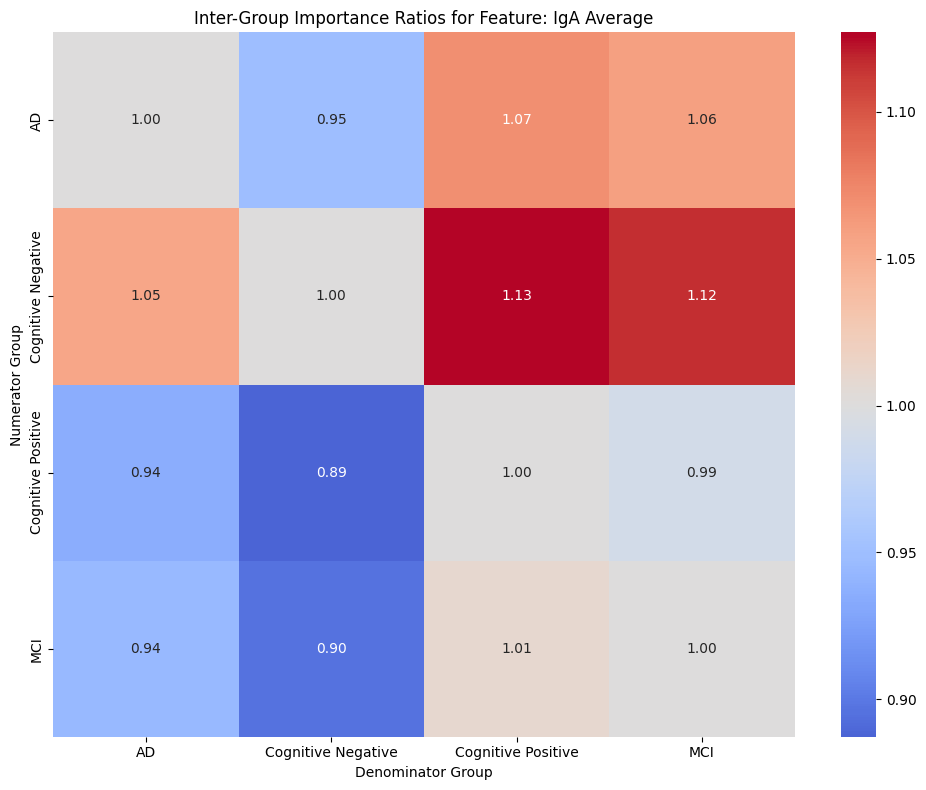

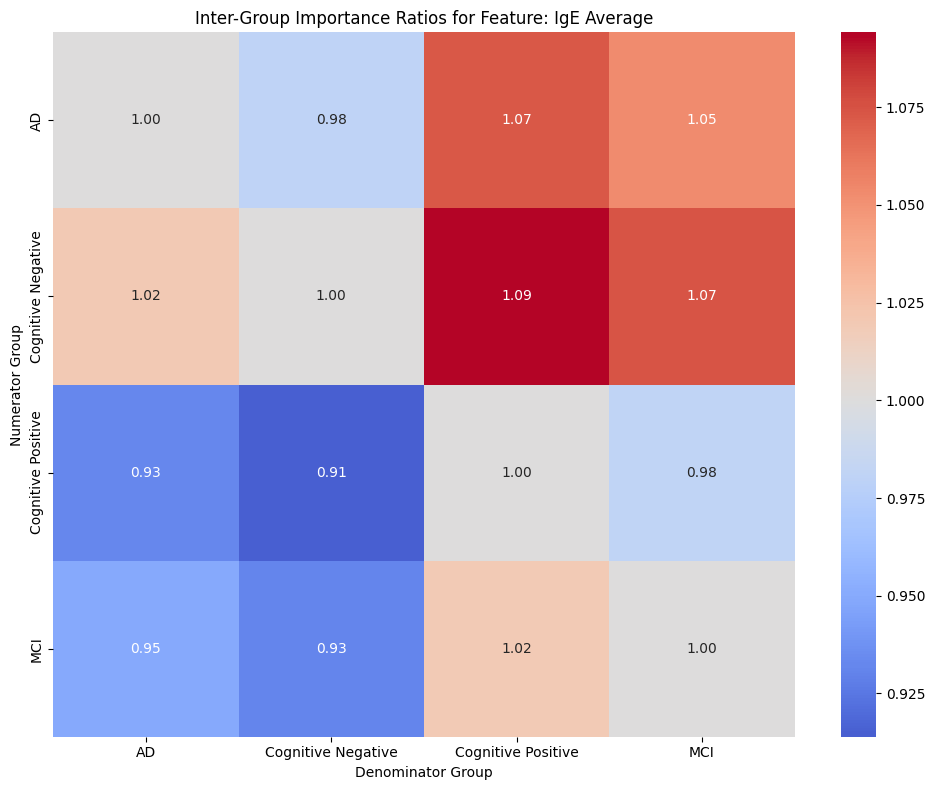

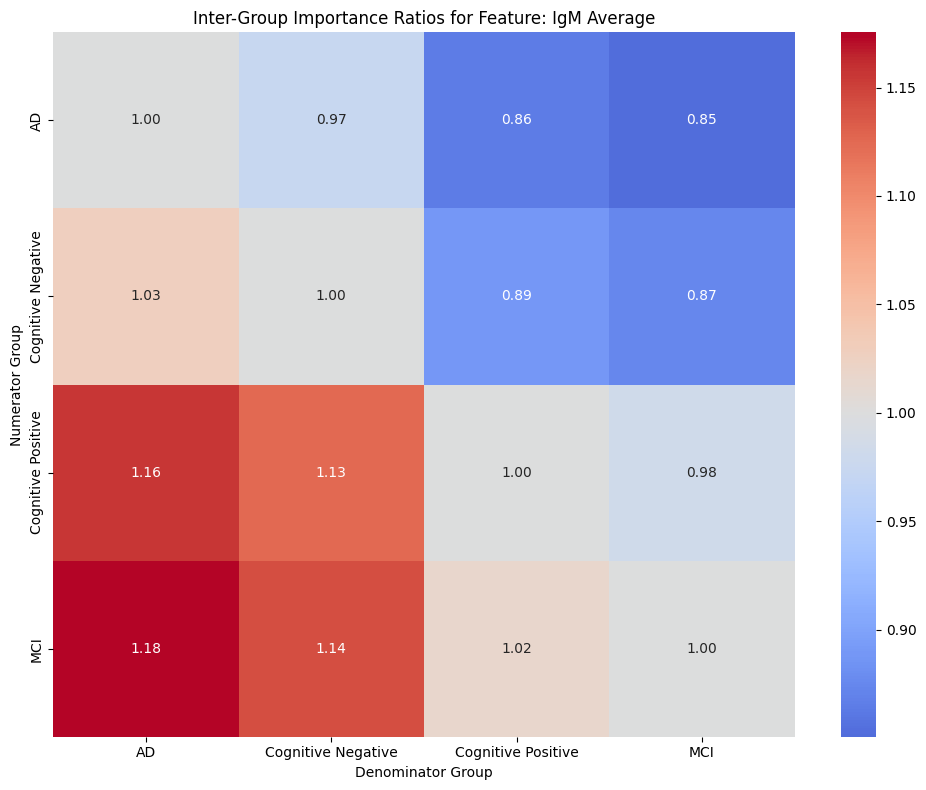

In [14]:
def calculate_feature_ratios(importance_df):

    groups = importance_df.index
    features = importance_df.columns
    ratio_results = {}

    for group in groups:
        # Create a DataFrame to store ratios for this group
        ratio_df = pd.DataFrame(index=features, columns=features)

        # Calculate ratios for all feature pairs
        for feature1 in features:
            for feature2 in features:
                if feature1 != feature2:  # Skip diagonal (same feature)
                    # Calculate ratio: feature1 / feature2
                    num = importance_df.loc[group, feature1]
                    denom = importance_df.loc[group, feature2]

                    if denom != 0 and not np.isnan(denom) and not np.isnan(num):  # Avoid division by zero and NaN
                        ratio = float(num / denom)
                    else:
                        ratio = 999.0  # Use a large number instead of infinity

                    ratio_df.loc[feature1, feature2] = ratio
                else:
                    ratio_df.loc[feature1, feature2] = 1.0  # Ratio of a feature with itself is 1

        ratio_results[group] = ratio_df

    return ratio_results

def calculate_intergroup_feature_ratios(importance_df):

    groups = importance_df.index
    features = importance_df.columns

    # Create a multi-level DataFrame to store all inter-group ratios
    index = pd.MultiIndex.from_product([groups, groups], names=['Numerator Group', 'Denominator Group'])
    intergroup_ratio_df = pd.DataFrame(index=index, columns=features)

    # Calculate ratios for all group pairs for each feature
    for feature in features:
        for num_group in groups:
            for denom_group in groups:
                if num_group != denom_group:  # Skip same group
                    # Calculate ratio: group1's feature importance / group2's feature importance
                    num = importance_df.loc[num_group, feature]
                    denom = importance_df.loc[denom_group, feature]

                    if denom != 0 and not np.isnan(denom) and not np.isnan(num):  # Avoid division by zero and NaN
                        ratio = float(num / denom)
                    else:
                        ratio = 999.0  # Use a large number instead of infinity

                    intergroup_ratio_df.loc[(num_group, denom_group), feature] = ratio
                else:
                    intergroup_ratio_df.loc[(num_group, denom_group), feature] = 1.0  # Ratio of a group with itself is 1

    return intergroup_ratio_df

def plot_feature_ratios(ratio_results):
    """
    Visualize feature ratios using heatmaps for each group.

    Parameters:
    ratio_results (dict): Dictionary with group names as keys and DataFrames of feature ratios as values.
    """
    for group, ratio_df in ratio_results.items():
        # Ensure all values are numeric and handle extreme values
        numeric_df = ratio_df.astype(float)

        # Cap extreme values for better visualization (between 0.1 and 10)
        # Values outside this range will still show in annotations but color will be capped
        plot_df = numeric_df.copy()
        plot_df[plot_df > 10] = 10
        plot_df[plot_df < 0.1] = 0.1

        plt.figure(figsize=(12, 10))
        sns.heatmap(plot_df, cmap='coolwarm', annot=numeric_df, fmt='.2f', center=1.0)
        plt.title(f'Feature Importance Ratios for Group: {group}')
        plt.xlabel('Denominator Feature')
        plt.ylabel('Numerator Feature')
        plt.tight_layout()
        plt.show()

        # # Print the top 5 highest ratios for this group
        # flat_ratios = []
        # for feature1 in ratio_df.index:
        #     for feature2 in ratio_df.columns:
        #         if feature1 != feature2:  # Skip diagonal
        #             flat_ratios.append({
        #                 'Numerator': feature1,
        #                 'Denominator': feature2,
        #                 'Ratio': ratio_df.loc[feature1, feature2]
        #             })

        # flat_df = pd.DataFrame(flat_ratios)
        # print(f"\nTop 5 highest feature ratios for group {group}:")
        # print(flat_df.sort_values('Ratio', ascending=False).head(5))



def plot_intergroup_feature_ratios(intergroup_ratio_df):
    """
    Visualize inter-group feature ratios using heatmaps for each feature.

    Parameters:
    intergroup_ratio_df (pd.DataFrame): DataFrame of feature ratios between groups.
    """
    features = intergroup_ratio_df.columns

    for feature in features:
        try:
            # Extract the ratios for this feature and reshape for visualization
            ratio_matrix = intergroup_ratio_df[feature].unstack()

            # Ensure all values are numeric
            numeric_matrix = ratio_matrix.astype(float)

            # Cap extreme values for better visualization (between 0.1 and 10)
            plot_matrix = numeric_matrix.copy()
            plot_matrix[plot_matrix > 10] = 10
            plot_matrix[plot_matrix < 0.1] = 0.1

            plt.figure(figsize=(10, 8))
            sns.heatmap(plot_matrix, cmap='coolwarm', annot=numeric_matrix, fmt='.2f', center=1.0)
            plt.title(f'Inter-Group Importance Ratios for Feature: {feature}')
            plt.xlabel('Denominator Group')
            plt.ylabel('Numerator Group')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting heatmap for feature {feature}: {e}")
            print("Showing raw data instead:")
            display(ratio_matrix)

    # # Print top 5 highest inter-group ratios across all features
    # flat_ratios = []
    # for idx, row in intergroup_ratio_df.iterrows():
    #     num_group, denom_group = idx
    #     if num_group != denom_group:  # Skip same group comparisons
    #         for feature in intergroup_ratio_df.columns:
    #             flat_ratios.append({
    #                 'Numerator Group': num_group,
    #                 'Denominator Group': denom_group,
    #                 'Feature': feature,
    #                 'Ratio': row[feature]
    #             })

    # flat_df = pd.DataFrame(flat_ratios)
    # print("\nTop 5 highest inter-group feature ratios:")
    # print(flat_df.sort_values('Ratio', ascending=False).head(5))

def analyze_feature_importance_ratios(importance_df):
    """
    Main function to analyze feature importance ratios within groups and between groups.

    Parameters:
    importance_df (pd.DataFrame): DataFrame containing feature importances per group.
                                 Rows are groups, columns are features.

    Returns:
    tuple: (intra_group_ratios, inter_group_ratios)
    """
    # Calculate intra-group feature ratios
    intra_group_ratios = calculate_feature_ratios(importance_df)

    # Plot intra-group feature ratios
    plot_feature_ratios(intra_group_ratios)

    # Calculate inter-group feature ratios
    inter_group_ratios = calculate_intergroup_feature_ratios(importance_df)

    # Plot inter-group feature ratios
    plot_intergroup_feature_ratios(inter_group_ratios)

    return intra_group_ratios, inter_group_ratios

intra_group_ratios, inter_group_ratios = analyze_feature_importance_ratios(importance_df)

**Make a prediction for a random data in test set and get detailed analysis regarding the tree decision and path taken to classify the input in a group.**

In [15]:
def predict_and_explain(Pumpkin, sample, feature_names):
    """
    Predict a sample and explain the decision process.
    """
    # Get the prediction and explanation
    explanation = explain_forest_decision(Pumpkin, sample, feature_names)

    # Convert numeric prediction to group name
    group_name = Pumpkin.classes_[int(explanation['final_prediction'])]
    print(f"\nPredicted Group: {group_name}")

    print("\nVotes from all trees:")
    for group, votes in explanation['tree_votes'].items():
        group_name = Pumpkin.classes_[int(group)]
        print(f"{group_name}: {votes} votes ({votes/len(Pumpkin.estimators_)*100:.1f}%)")

    print("\nFeature Importance in This Decision:")
    print(explanation['feature_importance'])

    print("\nExample Decision Paths (from 3 trees):")
    for i, path in enumerate(explanation['example_paths']):
        print(f"\nTree {i} decision path:")
        for rule in path:
            print(f"  {rule}")


def explain_forest_decision(Pumpkin, sample, feature_names):
    """
    Provide a detailed explanation of how the Random Forest makes its final decision.
    """
    predictions, decision_paths = analyze_single_prediction(Pumpkin, sample, feature_names)

    # Count predictions from each tree
    prediction_counts = pd.Series(predictions).value_counts()
    final_prediction = prediction_counts.index[0]

    # Analyze feature importance in the decision
    feature_usage = defaultdict(lambda: {'count': 0, 'thresholds': []})

    for path in decision_paths:
        for rule in path:
            # Split the rule at ≤ or > to preserve full feature name
            if '≤' in rule:
                feature = rule.split('≤')[0].strip()
                threshold = float(rule.split('≤')[1])
            else:
                feature = rule.split('>')[0].strip()
                threshold = float(rule.split('>')[1])

            feature_usage[feature]['count'] += 1
            feature_usage[feature]['thresholds'].append(threshold)

    # Convert to DataFrame for easier analysis and hide index
    feature_importance = pd.DataFrame({
        'feature': list(feature_usage.keys()),
        'usage_count': [d['count'] for d in feature_usage.values()],
        'avg_threshold': [np.mean(d['thresholds']) for d in feature_usage.values()]
    }).sort_values('usage_count', ascending=False)

    # Set feature as index and then hide the index name
    feature_importance.set_index('feature', inplace=True)
    feature_importance.index.name = None

    return {
        'final_prediction': final_prediction,
        'tree_votes': prediction_counts,
        'feature_importance': feature_importance,
        'example_paths': decision_paths[:3] # Change here to find the first 3 paths  or many paths.
    }


def analyze_single_prediction(Pumpkin, sample, feature_names): #3
    """
    Analyze how the Random Forest makes a prediction for a single sample by examining
    each tree's decision path.
    """
    # Get predictions from each tree
    predictions = []
    decision_paths = []

    for tree in Pumpkin.estimators_:
        # Get the decision path for this sample in this tree
        path = tree.decision_path([sample]).indices

        # Get the prediction from this tree
        pred = tree.predict([sample])[0]
        predictions.append(pred)

        # Extract the actual decision rules used
        rules = []
        for node_id in path:
            # Check if it's not a leaf node
            if tree.tree_.feature[node_id] != -2:
                feature = feature_names.columns[tree.tree_.feature[node_id]]
                threshold = tree.tree_.threshold[node_id]

                # Get the actual value for this feature in our sample
                feature_value = sample.iloc[tree.tree_.feature[node_id]]

                if feature_value <= threshold:
                    rules.append(f"{feature} ≤ {threshold:.2f}")
                else:
                    rules.append(f"{feature} > {threshold:.2f}")

        decision_paths.append(rules)

    return predictions, decision_paths


# def analyze_feature_contributions(Pumpkin, sample, feature_names):
#     """
#     Analyze feature contributions for a single prediction.
#     """
#     # Initialize tracking arrays
#     feature_used_count = np.zeros(len(feature_names))
#     feature_contributions = np.zeros(len(feature_names))

#     # Analyze each tree's contribution
#     for tree in Pumpkin.estimators_:
#         # Get decision path for this sample
#         decision_path = tree.decision_path(sample.values.reshape(1, -1))
#         node_indices = decision_path.indices

#         # Track features used and their contributions
#         for node_id in node_indices:
#             feature_id = tree.tree_.feature[node_id]
#             if feature_id >= 0:  # Not a leaf node
#                 feature_used_count[feature_id] += 1

#                 # Calculate contribution based on impurity reduction
#                 if node_id < len(tree.tree_.feature) - 1:
#                     impurity_decrease = tree.tree_.impurity[node_id] - tree.tree_.impurity[node_id + 1]
#                     feature_contributions[feature_id] += impurity_decrease

#     # Calculate final feature importance
#     feature_importance = feature_contributions * feature_used_count
#     feature_importance = feature_importance / np.sum(feature_importance)

#     return dict(zip(feature_names, feature_importance))


random_num = random.randint(0, len(X_test)-1)
sample = X_test.iloc[random_num]
print(f"\nTrue Group: {y_test.iloc[random_num]}")
print("Analyzing sample:")
for feature_name, value in sample.items():
    print(f"{feature_name}:    {value:.4f}")

predict_and_explain(Pumpkin, sample, feature_names)

# print("\n Feature Contributions Analysis ")
# contributions = analyze_feature_contributions(Pumpkin, sample_to_analyze, feature_names.columns)
# sorted_contributions = sorted(contributions.items(), key=lambda x: x[1], reverse=True)
# for feature, importance in sorted_contributions:
#     print(f"{feature}: {importance:.4f}")


True Group: Cognitive Negative
Analyzing sample:
IgG1 Average:    0.0075
IgG2 Average:    0.0485
IgG3 Average:    0.0130
IgG4 Average:    0.0125
IgA Average:    0.0220
IgE Average:    0.0085
IgM Average:    0.1525

Predicted Group: Cognitive Negative

Votes from all trees:
Cognitive Negative: 71 votes (71.0%)
MCI: 12 votes (12.0%)
AD: 11 votes (11.0%)
Cognitive Positive: 6 votes (6.0%)

Feature Importance in This Decision:
              usage_count  avg_threshold
IgA Average           123       0.011382
IgE Average            89       0.011461
IgM Average            74       0.152432
IgG4 Average           69       0.017391
IgG2 Average           61       0.045738
IgG1 Average           50       0.011200
IgG3 Average           48       0.010625

Example Decision Paths (from 3 trees):

Tree 0 decision path:
  IgA Average > 0.01
  IgG2 Average ≤ 0.05
  IgA Average > 0.02
  IgM Average > 0.12

Tree 1 decision path:
  IgA Average > 0.01
  IgE Average ≤ 0.01
  IgA Average > 0.01

Tree 2 de

**Median Threshold measured throughout the Decision Tree for the model**

In [16]:

def analyze_threshold(Pumpkin, X_train, feature_names):
    """
    Analyze decision paths in the Random Forest to determine feature thresholds for classification.
    """
    # Get feature thresholds from all trees
    feature_thresholds = {feature: [] for feature in feature_names}

    # Analyze a subset of trees (e.g., first 10) for clarity
    for tree_idx, tree in enumerate(Pumpkin.estimators_): #Pumpkin.estimators_[:10]
        # Get node threshold values for each feature
        for node_idx in range(tree.tree_.node_count):
            feature_idx = tree.tree_.feature[node_idx]
            if feature_idx != -2:  # Not a leaf node
                threshold = tree.tree_.threshold[node_idx]
                feature_name = feature_names.columns[feature_idx]
                feature_thresholds[feature_name].append(threshold)

    # Calculate median thresholds for each feature
    median_thresholds = {feature: np.median(thresholds)
                        for feature, thresholds in feature_thresholds.items()
                        if thresholds}

    return median_thresholds


# Analyze thresholds by feature
median_thresholds = analyze_threshold(Pumpkin, X_train, feature_names)
print("\nMedian Feature Thresholds:")
for feature, threshold in median_thresholds.items():
  print(f"{feature}: {threshold:.3f}")




Median Feature Thresholds:
IgG1 Average: 0.011
IgG2 Average: 0.044
IgG3 Average: 0.009
IgG4 Average: 0.016
IgA Average: 0.008
IgE Average: 0.014
IgM Average: 0.230


**Discriminative Patterns for Each Group**

In [17]:
def analyze_group_characteristics(data, feature_names, Group):

    group_characteristics = {}
    feature_names = feature_names.columns.tolist()
    features_df = pd.DataFrame(data, columns=feature_names)
    features_df['Group'] = Group

    for group in features_df['Group'].unique():
        group_data = features_df[features_df['Group'] == group]
        characteristics = {}

        for feature in feature_names:
            mean_val = group_data[feature].mean()
            std_val = group_data[feature].std()
            percentile_75 = group_data[feature].quantile(0.75)
            percentile_25 = group_data[feature].quantile(0.25)

            characteristics[feature] = {
                'mean': mean_val,
                'std': std_val,
                'high_threshold': percentile_75,
                'low_threshold': percentile_25
            }

        group_characteristics[group] = characteristics

    return group_characteristics

def identify_discriminative_features_simple(group_characteristics):

    discriminative_patterns = {}

    for group in group_characteristics:
        patterns = []
        chars = group_characteristics[group]

        for feature, stats in chars.items():
            other_groups_stats = [g_chars[feature]
                                for g, g_chars in group_characteristics.items()
                                if g != group]

            other_groups_means = [stats['mean'] for stats in other_groups_stats]
            mean_threshold = np.std(other_groups_means)

            if stats['mean'] > np.mean(other_groups_means) + mean_threshold:
                patterns.append(f"High {feature}")
            elif stats['mean'] < np.mean(other_groups_means) - mean_threshold:
                patterns.append(f"Low {feature}")

        discriminative_patterns[group] = patterns

    return discriminative_patterns

def identify_discriminative_features_pairwise(group_characteristics):

    discriminative_patterns = {}

    for group in group_characteristics:
        patterns = []
        chars = group_characteristics[group]

        for feature, stats in chars.items():
            feature_patterns = []

            for other_group, other_chars in group_characteristics.items():
                if other_group == group:
                    continue

                other_stats = other_chars[feature]
                mean_difference = stats['mean'] - other_stats['mean']
                threshold_difference = (stats['low_threshold'] -
                                     other_stats['high_threshold'])

                if (mean_difference > other_stats['std'] and
                    stats['low_threshold'] > other_stats['high_threshold']):
                    feature_patterns.append(f"Higher than {other_group}")
                elif (mean_difference < -other_stats['std'] and
                      stats['high_threshold'] < other_stats['low_threshold']):
                    feature_patterns.append(f"Lower than {other_group}")

            if feature_patterns:
                summary = f"{feature}: " + ", ".join(feature_patterns)
                patterns.append(summary)

        discriminative_patterns[group] = patterns

    return discriminative_patterns

def print_discriminative_patterns(discriminative_patterns, analysis_name=""):

    print(f"\nDiscriminative Patterns for Each Group{analysis_name}:")
    for group, patterns in discriminative_patterns.items():
        print(f"\n{group}:")
        for pattern in patterns:
            print(f"- {pattern}")


# Analyze group characteristics
group_characteristics = analyze_group_characteristics(
        data, feature_names, Group)

# Run only the simple and pairwise analyses
patterns_simple = identify_discriminative_features_simple(group_characteristics)
print_discriminative_patterns(patterns_simple, " (Simple Analysis, mean)")

patterns_pairwise = identify_discriminative_features_pairwise(group_characteristics)
print_discriminative_patterns(patterns_pairwise, " (Pairwise Analysis)")


Discriminative Patterns for Each Group (Simple Analysis, mean):

Cognitive Positive:
- High IgG3 Average
- Low IgG4 Average
- Low IgA Average

Cognitive Negative:
- Low IgG2 Average
- High IgG4 Average
- High IgA Average
- Low IgE Average

AD:
- High IgG1 Average
- Low IgG3 Average
- High IgA Average
- High IgE Average

MCI:
- Low IgG1 Average
- Low IgM Average

Discriminative Patterns for Each Group (Pairwise Analysis):

Cognitive Positive:
- IgA Average: Lower than Cognitive Negative

Cognitive Negative:
- IgA Average: Higher than Cognitive Positive
- IgE Average: Lower than AD

AD:
- IgE Average: Higher than Cognitive Negative

MCI:


Data Correaltion plotting

       IgG1 Average  IgG2 Average  IgG3 Average  IgG4 Average  IgA Average  \
count    256.000000    256.000000    256.000000    256.000000   256.000000   
mean       0.011035      0.045158      0.009965      0.019541     0.008010   
std        0.003405      0.019286      0.003433      0.013474     0.005024   
min        0.003000      0.007500      0.002500      0.002500    -0.003000   
25%        0.008500      0.029500      0.007500      0.010000     0.004500   
50%        0.011000      0.043250      0.010000      0.015000     0.007500   
75%        0.013000      0.058125      0.012500      0.025125     0.011000   
max        0.019500      0.103500      0.021000      0.062000     0.023500   

       IgE Average  IgM Average  
count   256.000000   256.000000  
mean      0.013332     0.231291  
std       0.004991     0.070649  
min       0.004000     0.065500  
25%       0.009500     0.198625  
50%       0.012500     0.242000  
75%       0.017000     0.280000  
max       0.027500     0.

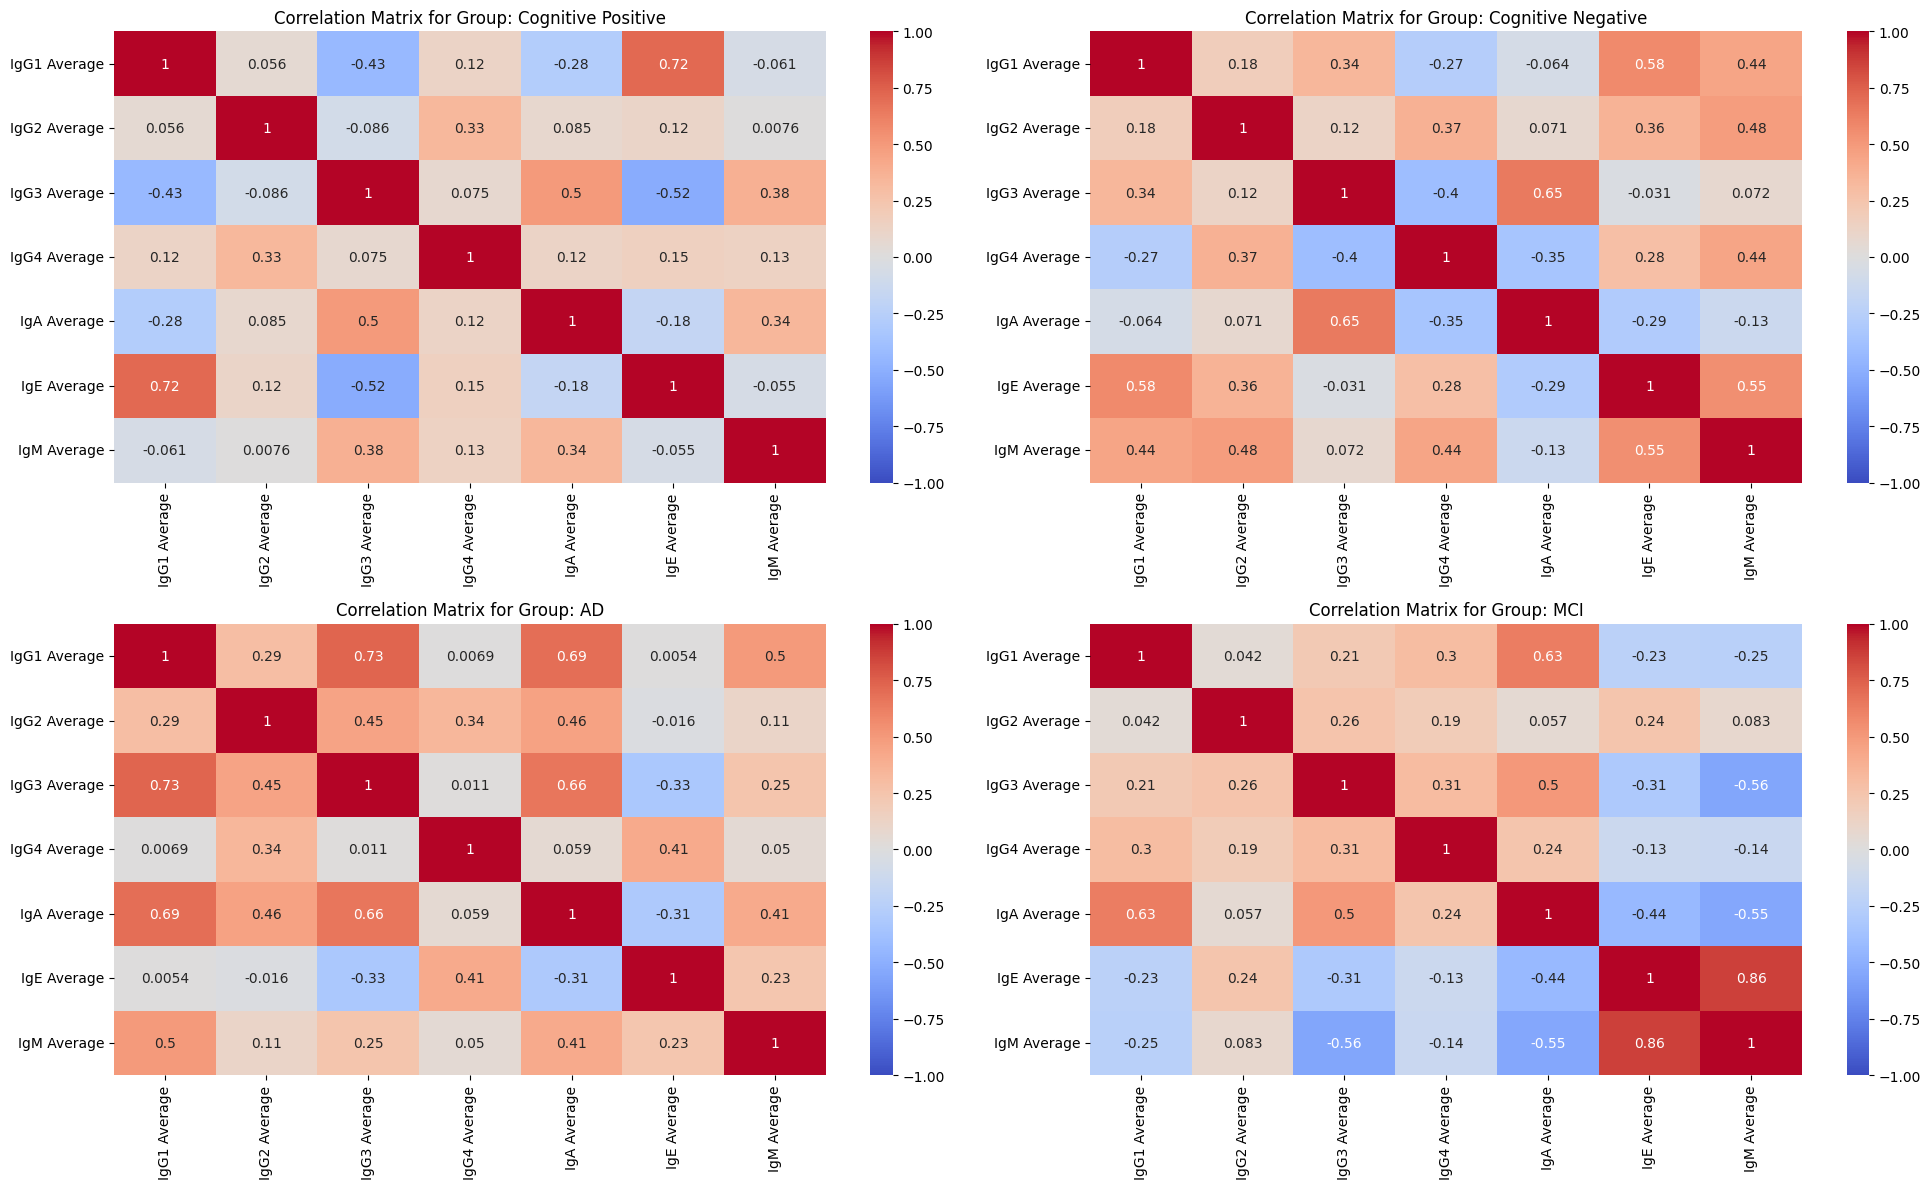


Top Feature Correlations by Group:

Group: Cognitive Positive
  IgE Average & IgG1 Average: 0.7178
  IgE Average & IgG3 Average: 0.5182
  IgA Average & IgG3 Average: 0.4981

Group: Cognitive Negative
  IgA Average & IgG3 Average: 0.6480
  IgE Average & IgG1 Average: 0.5763
  IgM Average & IgE Average: 0.5518

Group: AD
  IgG3 Average & IgG1 Average: 0.7338
  IgA Average & IgG1 Average: 0.6890
  IgA Average & IgG3 Average: 0.6594

Group: MCI
  IgM Average & IgE Average: 0.8644
  IgA Average & IgG1 Average: 0.6295
  IgM Average & IgG3 Average: 0.5614


In [18]:
print(data.describe()) #319 -> 209
print(data.info())
print(data.isnull().sum())


def plot_correlation_by_group(data, feature_names, Group):

    groups = data['Group'].unique()

    # Set up a grid of subplots based on number of groups
    rows = (len(groups) + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
    axes = axes.flatten() if rows > 1 else [axes]

    for i, group in enumerate(groups):
        # Filter data for the current group
        group_data = data[data['Group'] == group]

        # Calculate correlation matrix
        corr_matrix = group_data[feature_names].corr()

        # Plot heatmap
        sns.heatmap(corr_matrix,
                    annot=True,
                    cmap='coolwarm',
                    vmin=-1,
                    vmax=1,
                    ax=axes[i])
        axes[i].set_title(f'Correlation Matrix for Group: {group}')

    # If there are unused subplots, hide them
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Also return a dictionary of correlation matrices for further analysis
    correlation_dict = {}
    for group in groups:
        group_data = data[data['Group'] == group]
        correlation_dict[group] = group_data[feature_names].corr()

    return correlation_dict

# Use the function with your data
correlation_dict = plot_correlation_by_group(data, feature_names.columns, Group)

# Print the top correlations for each group
print("\nTop Feature Correlations by Group:")
for group, corr_matrix in correlation_dict.items():
    print(f"\nGroup: {group}")

    # Get the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find the top 3 strongest correlations (absolute value)
    strongest_corrs = upper.abs().unstack().sort_values(ascending=False).head(3)

    for idx, corr in strongest_corrs.items():
        feature1, feature2 = idx
        print(f"  {feature1} & {feature2}: {corr:.4f}")

**Generate Ratio of IG Profile **

In [ ]:
uploadedSpreadsheet = files.upload()
fileName = list(uploadedSpreadsheet.keys())[0]
data = pd.read_excel(fileName)

columns_to_process = [ 'IgG3 Average_IgG4 Average', 'IgG3 Average_IgA Average', 'IgG3 Average_IgE Average','IgG4 Average_IgG3 Average',
                     'IgG4 Average_IgA Average', 'IgG4 Average_IgE Average','IgA Average_IgG3 Average',
                     'IgA Average_IgG4 Average', 'IgA Average_IgE Average', 'IgE Average_IgG3 Average',
                     'IgE Average_IgG4 Average', 'IgE Average_IgA Average']


                    #  ['IgG1 Average_IgG2 Average', 'IgG1 Average_IgG3 Average', 'IgG1 Average_IgG4 Average',
                    #  'IgG1 Average_IgA Average', 'IgG1 Average_IgE Average', 'IgG1 Average_IgM Average',
                    #   'IgG2 Average_IgG1 Average', 'IgG2 Average_IgG3 Average', 'IgG2 Average_IgG4 Average',
                    #   'IgG2 Average_IgA Average', 'IgG2 Average_IgE Average', 'IgG2 Average_IgM Average',
                    #  'IgG3 Average_IgG1 Average', 'IgG3 Average_IgG2 Average', 'IgG3 Average_IgG4 Average',
                    #  'IgG3 Average_IgA Average', 'IgG3 Average_IgE Average', 'IgG3 Average_IgM Average',
                    #  'IgG4 Average_IgG1 Average', 'IgG4 Average_IgG2 Average', 'IgG4 Average_IgG3 Average',
                    #  'IgG4 Average_IgA Average', 'IgG4 Average_IgE Average', 'IgG4 Average_IgM Average',
                    #  'IgA Average_IgG1 Average', 'IgA Average_IgG2 Average', 'IgA Average_IgG3 Average',
                    #  'IgA Average_IgG4 Average', 'IgA Average_IgE Average', 'IgA Average_IgM Average',
                    #  'IgE Average_IgG1 Average', 'IgE Average_IgG2 Average', 'IgE Average_IgG3 Average',
                    #  'IgE Average_IgG4 Average', 'IgE Average_IgA Average', 'IgE Average_IgM Average',
                    #  'IgM Average_IgG1 Average', 'IgM Average_IgG2 Average', 'IgM Average_IgG3 Average',
                    #  'IgM Average_IgG4 Average', 'IgM Average_IgA Average', 'IgM Average_IgE Average']

# Get unique groups
groups = data['Group'].unique().tolist()
print(f"Found {len(groups)} groups: {groups}")

# Create Excel writer
output_filename = 'immunoglobulin_ratios_analysis.xlsx'
with pd.ExcelWriter(output_filename) as writer:

    # Create placeholder sheet to ensure we have at least one sheet
    pd.DataFrame(['Analysis Results']).to_excel(writer, sheet_name='Info', index=False)

    # Process each column for each group
    for column in columns_to_process:

        for group in groups:
            # Filter data for this group
            group_data = data[data['Group'] == group]

            # Skip if empty group
            if len(group_data) == 0:
                continue

            # Get valid values (non-NaN, non-infinite, numeric values only)
            valid_values = []
            for idx, row in group_data.iterrows():
                value = row[column]
                if isinstance(value, (int, float)) and not math.isnan(value) and not math.isinf(value):
                    if str(value) != "#DIV/0!":
                        valid_values.append({
                            'value': value,
                            'row': idx + 2,  # Excel row (1-based + header)
                            'Sample ID': str(row['Sample ID']),
                            'Cohort': str(row['Cohort']),
                            'Group': group
                        })

            # Skip if no valid values
            if not valid_values:
                continue

            # Sort values
            sorted_values = sorted(valid_values, key=lambda x: x['value'])

            # Get top 15 (or fewer if we don't have 15)
            num_to_take = min(15, len(sorted_values))
            lowest = sorted_values[:num_to_take]
            highest = sorted_values[-num_to_take:][::-1]  # Reverse for descending order

            # Create short names for sheets (Excel has a 31 char limit)
            col_short = column.replace(' Average', '').replace('_', '-')[:20]
            col_short = col_short.replace(' ', '_')

            # Create sheets for lowest values
            if lowest:
                sheet_name = f"{col_short}_{group}_Low"[:31]
                lowest_df = pd.DataFrame(lowest)
                lowest_df.to_excel(writer, sheet_name=sheet_name, index=False)

            # Create sheets for highest values
            if highest:
                sheet_name = f"{col_short}_{group}_High"[:31]
                highest_df = pd.DataFrame(highest)
                highest_df.to_excel(writer, sheet_name=sheet_name, index=False)

# For Google Colab, download the file
try:
    from google.colab import files
    files.download(output_filename)
    print(f"Excel file has been created and downloaded: {output_filename}")
except ImportError:
    print(f"Excel file has been created: {output_filename}")

**Create a RF model with Ratio and Ig Profile**

In [ ]:
# Load data
uploadedSpreadsheet = files.upload()
fileName = list(uploadedSpreadsheet.keys())[0]
data = pd.read_excel(fileName)

# First set of columns for outlier removal
initial_columns_to_process = ['IgG1 Average', 'IgG2 Average', 'IgG3 Average', 'IgG4 Average', 'IgA Average','IgE Average','IgM Average']

def OutlierRemoval(data, columns):
    data_filtered = data.copy()

    for column in columns:
        Q1 = data_filtered[column].quantile(0.25)
        Q3 = data_filtered[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data_filtered = data_filtered[(data_filtered[column] >= lower_bound) &
                                      (data_filtered[column] <= upper_bound)]

    return data_filtered

def SaveData(Pumpkin):
    joblib.dump(Pumpkin, f"Trained_Model_Pumpkin{datetime.date.today()}.pkl")
    return f"Data saved to 'Trained_Model_Pumpkin{datetime.date.today()}.pkl'"

# Remove outliers on initial columns
data = OutlierRemoval(data, initial_columns_to_process)

# Full list of columns for model training
columns_to_process = ['IgG1 Average', 'IgG2 Average', 'IgG3 Average', 'IgG4 Average', 'IgA Average','IgE Average','IgM Average',
                     'IgG1 Average_IgG2 Average', 'IgG1 Average_IgG3 Average', 'IgG1 Average_IgG4 Average',
                     'IgG1 Average_IgA Average', 'IgG1 Average_IgE Average', 'IgG1 Average_IgM Average',
                     'IgG2 Average_IgG1 Average', 'IgG2 Average_IgG3 Average', 'IgG2 Average_IgG4 Average',
                     'IgG2 Average_IgA Average', 'IgG2 Average_IgE Average', 'IgG2 Average_IgM Average',
                     'IgG3 Average_IgG1 Average', 'IgG3 Average_IgG2 Average', 'IgG3 Average_IgG4 Average',
                     'IgG3 Average_IgA Average', 'IgG3 Average_IgE Average', 'IgG3 Average_IgM Average',
                     'IgG4 Average_IgG1 Average', 'IgG4 Average_IgG2 Average', 'IgG4 Average_IgG3 Average',
                     'IgG4 Average_IgA Average', 'IgG4 Average_IgE Average', 'IgG4 Average_IgM Average',
                     'IgA Average_IgG1 Average', 'IgA Average_IgG2 Average', 'IgA Average_IgG3 Average',
                     'IgA Average_IgG4 Average', 'IgA Average_IgE Average', 'IgA Average_IgM Average',
                     'IgE Average_IgG1 Average', 'IgE Average_IgG2 Average', 'IgE Average_IgG3 Average',
                     'IgE Average_IgG4 Average', 'IgE Average_IgA Average', 'IgE Average_IgM Average',
                     'IgM Average_IgG1 Average', 'IgM Average_IgG2 Average', 'IgM Average_IgG3 Average',
                     'IgM Average_IgG4 Average', 'IgM Average_IgA Average', 'IgM Average_IgE Average']

# Function to clean data by removing zeros and #DIV/0! errors
def clean_data(df, columns_list):
    # Create a copy of the dataframe
    df_clean = df.copy()

    # Replace Excel's #DIV/0! error (which pandas typically imports as string or error value)
    # First, replace any strings that might contain "#DIV/0!"
    for col in columns_list:
        if df_clean[col].dtype == object:  # If column contains strings
            df_clean[col] = df_clean[col].replace("#DIV/0!", np.nan)
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')  # Convert to numeric

    # Create mask for rows with zeros in specified columns
    zero_mask = pd.Series(True, index=df_clean.index)
    for col in columns_list:
        zero_mask = zero_mask & (df_clean[col] != 0)

    # Create mask for rows with NaN values in specified columns
    nan_mask = df_clean[columns_list].notna().all(axis=1)

    # Apply both masks to remove rows with zeros or NaNs
    df_filtered = df_clean[zero_mask & nan_mask]

    # Print how many rows were removed
    print(f"Original row count: {len(df)}")
    print(f"Rows with zeros or #DIV/0! errors: {len(df) - len(df_filtered)}")
    print(f"Remaining row count: {len(df_filtered)}")

    return df_filtered

# Apply cleaning to remove zeros and #DIV/0! errors
data = clean_data(data, columns_to_process)

# Save cleaned data to Excel file
output_file = "after_outlier_and_cleaning.xlsx"
data.to_excel(output_file, index=False)
print(f"Clean data saved to '{output_file}'")

# Continue with model training if enough data remains
if len(data) > 10:  # Arbitrary threshold, adjust as needed
    feature_names = data[columns_to_process]
    Group = data['Group']

    # Model Creation
    X_train, X_test, y_train, y_test = train_test_split(feature_names, Group, test_size=0.3, random_state=42, stratify=Group)
    Pumpkin = RandomForestClassifier(n_estimators=100, random_state=100, bootstrap=True)
    Pumpkin.fit(X_train, y_train)
    y_pred = Pumpkin.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score: {accuracy:.4f}')

    # Save the Model
    save_message = SaveData(Pumpkin)
    print(save_message)
else:
    print("WARNING: Too few samples remain after cleaning. Model training aborted.")

**Voting Classifier**

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

X = feature_names
y = Group

# 1. Create your base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svc = SVC(probability=True, random_state=42)  # probability=True is required for soft voting
lr = LogisticRegression(random_state=42)

# 2. Create the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('lr', lr)],
    voting='hard'  # 'soft' uses predicted probabilities, 'hard' uses predicted class labels
)

# 3. Option A: Train and evaluate on a train/test split
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Get detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 4. Option B: Use cross-validation for more robust evaluation
cv_scores = cross_val_score(voting_clf, X, y, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


# Compare models using cross-validation
models = {
    'Random Forest': rf,
    'SVC': svc,
    'Logistic Regression': lr,
    'Voting Classifier': voting_clf
}

# Evaluate each model with cross-validation
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name} - Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

**Resources**

https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html

https://scikit-learn.org/stable/modules/ensemble.html#forest


https://www.w3schools.com/python/python_intro.asp?goalId=0b45f5e9-e5ad-43f9-8b49-dcc82a33195a

https://seaborn.pydata.org/tutorial/introduction.html

https://github.com/scikit-learn-contrib/boruta_py

In [ ]:
import pandas as pd
import numpy as np
import joblib
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import all classifiers
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV
from sklearn.neural_network import MLPClassifier

# Function to remove outliers (same as your original code)
def OutlierRemoval(data, columns):
    data_filtered = data.copy()

    for column in columns:
        Q1 = data_filtered[column].quantile(0.25)
        Q3 = data_filtered[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data_filtered = data_filtered[(data_filtered[column] >= lower_bound) &
                                      (data_filtered[column] <= upper_bound)]

    return data_filtered

# Function to save model
def SaveModel(model, model_name, prefix="Best_Model_"):
    filename = f"{prefix}{model_name}_{datetime.date.today()}.pkl"
    joblib.dump(model, filename)
    return f"Model saved to '{filename}'"

def main():
    # Load data - adjust based on your environment
    # If using file upload
    uploadedSpreadsheet = files.upload()
    fileName = list(uploadedSpreadsheet.keys())[0]
    data = pd.read_excel(fileName)


    # Define columns to process
    columns_to_process = ['IgG1 Average', 'IgG2 Average', 'IgG3 Average', 'IgG4 Average',
                          'IgA Average', 'IgE Average', 'IgM Average']

    # Remove outliers
    data_cleaned = OutlierRemoval(data, columns_to_process)
    print(f"Original data shape: {data.shape}, After outlier removal: {data_cleaned.shape}")

    # Save cleaned data
    data_cleaned.to_excel("cleaned_data.xlsx", index=False)

    # Prepare features and target
    X = data_cleaned[columns_to_process]
    y = data_cleaned['Group']  # Using 'Group' as in your original classification script

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Define all classifiers to evaluate
    classifiers = {
        "BernoulliNB": BernoulliNB(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "ExtraTreeClassifier": ExtraTreeClassifier(random_state=42),
        "ExtraTreesClassifier": ExtraTreesClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "LabelPropagation": LabelPropagation(),
        "LabelSpreading": LabelSpreading(),
        "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
        "LinearSVC": LinearSVC(multi_class="crammer_singer", random_state=42, max_iter=10000),
        "LogisticRegression": LogisticRegression(random_state=42, max_iter=10000),
        "LogisticRegressionCV": LogisticRegressionCV(random_state=42, max_iter=10000),
        "MLPClassifier": MLPClassifier(random_state=42, max_iter=1000),
        "NearestCentroid": NearestCentroid(),
        "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis(),
        "RadiusNeighborsClassifier": RadiusNeighborsClassifier(radius=10.0, outlier_label='most_frequent'),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "RidgeClassifier": RidgeClassifier(random_state=42),
        "RidgeClassifierCV": RidgeClassifierCV()
    }

    # Results storage
    results = {}
    cv_results = {}
    best_models = {}
    model_details = {}

    # Test each classifier
    print("\n===== MODEL EVALUATION =====")
    for name, clf in classifiers.items():
        print(f"\nTraining and evaluating {name}...")
        try:
            # Train model
            clf.fit(X_train, y_train)

            # Predict and evaluate
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            results[name] = acc

            # Store detailed metrics
            report = classification_report(y_test, y_pred, output_dict=True)
            conf_matrix = confusion_matrix(y_test, y_pred)
            model_details[name] = {
                'accuracy': acc,
                'report': report,
                'confusion_matrix': conf_matrix
            }

            # Cross-validation
            cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
            cv_results[name] = cv_scores.mean()

            # Store best models
            best_models[name] = clf

            # Print results
            print(f"Test Accuracy: {acc:.4f}")
            print(f"Cross-validation Accuracy: {cv_scores.mean():.4f}")

        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            results[name] = 0
            cv_results[name] = 0

    # Sort results by accuracy
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

    # Print overall results
    print("\n===== OVERALL RESULTS =====")
    print("\nAccuracy on Test Set:")
    for name, acc in sorted_results:
        print(f"{name}: {acc:.4f}")

    # Print cross-validation results
    print("\nMean Cross-validation Accuracy:")
    sorted_cv = sorted(cv_results.items(), key=lambda x: x[1], reverse=True)
    for name, cv_acc in sorted_cv:
        print(f"{name}: {cv_acc:.4f}")

    # Save the best model based on cross-validation
    best_model_name = sorted_cv[0][0]
    best_model = best_models[best_model_name]
    save_result = SaveModel(best_model, best_model_name)
    print(f"\nBest model: {best_model_name}")
    print(save_result)

    # Print detailed report for the best model
    print("\nDetailed Performance of Best Model:")
    details = model_details[best_model_name]
    print(f"Accuracy: {details['accuracy']:.4f}")
    print("\nClassification Report:")
    for label, metrics in details['report'].items():
        if isinstance(metrics, dict):
            print(f"{label}:")
            for metric_name, value in metrics.items():
                if isinstance(value, float):
                    print(f"  {metric_name}: {value:.4f}")
                else:
                    print(f"  {metric_name}: {value}")

    # Create a bar chart of model accuracies
    plt.figure(figsize=(15, 10))
    models = [x[0] for x in sorted_results]
    accuracies = [x[1] for x in sorted_results]

    bars = plt.barh(models, accuracies)
    plt.xlabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xlim(0, 1.0)

    # Add accuracy values at the end of each bar
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{acc:.4f}',
                 va='center')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    print("\nModel comparison chart saved to 'model_comparison.png'")

if __name__ == "__main__":
    main()

**Def format Create models **

In [ ]:
def load_data():
    uploadedSpreadsheet = files.upload()
    fileName = list(uploadedSpreadsheet.keys())[0]
    data = pd.read_excel(fileName)
    return data


columns_to_process = ['IgG1 Average', 'IgG2 Average', 'IgG3 Average', 'IgG4 Average', 'IgA Average','IgE Average','IgM Average']#,
                     # 'IgG1 Average_IgG2 Average', 'IgG1 Average_IgG3 Average', 'IgG1 Average_IgG4 Average',
                     # 'IgG1 Average_IgA Average', 'IgG1 Average_IgE Average', 'IgG1 Average_IgM Average',
                      #'IgG2 Average_IgG1 Average', 'IgG2 Average_IgG3 Average', 'IgG2 Average_IgG4 Average',
                      #'IgG2 Average_IgA Average', 'IgG2 Average_IgE Average', 'IgG2 Average_IgM Average',
                     # 'IgG3 Average_IgG1 Average', 'IgG3 Average_IgG2 Average', 'IgG3 Average_IgG4 Average',
                     # 'IgG3 Average_IgA Average', 'IgG3 Average_IgE Average', 'IgG3 Average_IgM Average',
                     # 'IgG4 Average_IgG1 Average', 'IgG4 Average_IgG2 Average', 'IgG4 Average_IgG3 Average',
                     # 'IgG4 Average_IgA Average', 'IgG4 Average_IgE Average', 'IgG4 Average_IgM Average',
                     # 'IgA Average_IgG1 Average', 'IgA Average_IgG2 Average', 'IgA Average_IgG3 Average',
                     # 'IgA Average_IgG4 Average', 'IgA Average_IgE Average', 'IgA Average_IgM Average',
                     # 'IgE Average_IgG1 Average', 'IgE Average_IgG2 Average', 'IgE Average_IgG3 Average',
                     # 'IgE Average_IgG4 Average', 'IgE Average_IgA Average', 'IgE Average_IgM Average',
                    #  'IgM Average_IgG1 Average', 'IgM Average_IgG2 Average', 'IgM Average_IgG3 Average',
                    #  'IgM Average_IgG4 Average', 'IgM Average_IgA Average', 'IgM Average_IgE Average']


def remove_outliers(data, columns):


    data_filtered = data.copy()

    for column in columns:
        Q1 = data_filtered[column].quantile(0.25)
        Q3 = data_filtered[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data_filtered = data_filtered[(data_filtered[column] >= lower_bound) &
                                     (data_filtered[column] <= upper_bound)]

    return data_filtered


def preprocess_data(data, columns_to_process):

    # Remove outliers
    data = remove_outliers(data, columns_to_process)

    # Save processed data to Excel
    output_file = "after_outlier.xlsx"
    data.to_excel(output_file, index=False)
    print(f"Processed data saved to '{output_file}'")

    # Extract features and target
    feature_names = data[columns_to_process]
    Group = data['Group']

    return data, feature_names, Group


def train_initial_model(feature_names, Group, n_estimators=100, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split( feature_names, Group, test_size=0.3, random_state=42, stratify=Group)
    Pumpkin = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state,  bootstrap=True)
    Pumpkin.fit(X_train, y_train)

    return Pumpkin, X_train, X_test, y_train, y_test


def evaluate_model(Pumpkin, X_test, y_test):
    y_pred = Pumpkin.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    metrics = {
        'accuracy': accuracy,
        'f1_score': report['weighted avg']['f1-score'],
        'report': report,
        'confusion_matrix': conf_matrix,
        'predictions': y_pred
    }

    return metrics


def perform_multiple_evaluations(feature_names, Group, num_iterations=10):
    train_indexes = []
    test_indexes = []
    accuracies = []
    models = []
    evaluation_results = {}

    print("\n--- Multiple Train-Test Split Evaluation ---")

    for i in range(1, num_iterations + 1):
        print(f"\nIteration {i}/{num_iterations}")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            feature_names, Group, test_size=0.3, shuffle=True,
            random_state=i, stratify=Group
        )

        # Store indexes
        train_indexes.append(X_train.index)
        test_indexes.append(X_test.index)

        # Train model
        Pumpkin = RandomForestClassifier(
            n_estimators=100,
            random_state=100,
            bootstrap=True
        )
        Pumpkin.fit(X_train, y_train)
        models.append(Pumpkin)

        # Evaluate
        metrics = evaluate_model(Pumpkin, X_test, y_test)
        accuracies.append(metrics['accuracy'])

        print(f'Iteration {i} Accuracy: {metrics["accuracy"]:.4f}')
        print(f"Weighted F1-score: {metrics['f1_score']:.4f}")

    # Print overall stats
    print("\n--- Overall Performance Statistics ---")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Standard Deviation: {np.std(accuracies):.4f}")
    print(f"Min Accuracy: {np.min(accuracies):.4f}")
    print(f"Max Accuracy: {np.max(accuracies):.4f}")

    # Select best model
    best_model_idx = np.argmax(accuracies)
    best_model = models[best_model_idx]
    print(f"\nBest model from iteration {best_model_idx + 1} with accuracy: {accuracies[best_model_idx]:.4f}")

    # Evaluate best model
    best_X_test_idx = test_indexes[best_model_idx]
    X_test_best = feature_names.loc[best_X_test_idx]
    y_test_best = Group.loc[best_X_test_idx]

    best_metrics = evaluate_model(best_model, X_test_best, y_test_best)

    print("\nClassification Report (Best Model):")
    print(classification_report(y_test_best, best_metrics['predictions']))

    print("\nConfusion Matrix (Best Model):")
    print(best_metrics['confusion_matrix'])

    # Store results
    evaluation_results = {
        'models': models,
        'best_model_index': best_model_idx,
        'best_model': best_model,
        'accuracies': accuracies,
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'train_indexes': train_indexes,
        'test_indexes': test_indexes
    }

    return models, best_model, evaluation_results


def analyze_feature_importance(model, columns_to_process):
    feature_importance = pd.DataFrame({
        'Feature': columns_to_process,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    return feature_importance


def perform_cross_validation(model, feature_names, Group, cv=5):
    cv_scores = cross_val_score(model, feature_names, Group, cv=cv)

    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

    return cv_scores, cv_scores.mean()


def optimize_hyperparameters(feature_names, Group):
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Create GridSearchCV
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    # Fit to data
    grid_search.fit(feature_names, Group)

    # Get best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Print results
    print(f"\nBest parameters: {best_params}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # Sort and print results
    results = zip(
        grid_search.cv_results_['mean_test_score'],
        grid_search.cv_results_['params']
    )
    sorted_results = sorted(results, key=lambda x: x[0], reverse=True)

    print("Models sorted by descending accuracy:")
    for i, (mean_score, params) in enumerate(sorted_results[:5]):  # Show top 5
        print(f"{i+1}. Accuracy: {mean_score:.4f} with parameters: {params}")

    return best_params, best_model, grid_search


def SaveModel(model, prefix="Pumpkin_Trained_Model_"):
    filename = f"{prefix}{datetime.date.today()}.pkl"
    joblib.dump(model, filename)
    return f"Model saved to '{filename}'"


def SaveData(Pumpkin):
    joblib.dump(Pumpkin, f"Trained_Model_Pumpkin{datetime.date.today()}.pkl")
    return f"Data saved to \'Trained_Model_Pumpkin{datetime.date.today()}.pkl\'"


def main():
    # Load data
    print("Loading data...")
    data = load_data()

    # Preprocess data
    print("\nPreprocessing data and removing outliers...")
    data, feature_names, Group = preprocess_data(data, columns_to_process)

    # Train initial model
    print("\nTraining initial model...")
    Pumpkin, X_train, X_test, y_train, y_test = train_initial_model(feature_names, Group)

    # Evaluate initial model
    print("\nEvaluating initial model...")
    initial_metrics = evaluate_model(Pumpkin, X_test, y_test)
    print(f"Initial model accuracy: {initial_metrics['accuracy']:.4f}")

    # Perform multiple evaluations
    print("\nPerforming multiple evaluations...")
    models, best_model, eval_results = perform_multiple_evaluations(feature_names, Group)

    # Analyze feature importance
    print("\nAnalyzing feature importance...")
    feature_importance = analyze_feature_importance(best_model, columns_to_process)

    # Perform cross-validation
    print("\nPerforming cross-validation...")
    cv_scores, mean_cv = perform_cross_validation(best_model, feature_names, Group)

    # Optimize hyperparameters
    print("\nOptimizing hyperparameters...")
    best_params, optimized_model, grid_search = optimize_hyperparameters(feature_names, Group)

    # Save models
    print("\nSaving models...")
    initial_save_msg = SaveModel(Pumpkin, "Pumpkin_Initial_Model_")
    best_save_msg = SaveModel(best_model, "Pumpkin_Best_Model_")
    optimized_save_msg = SaveModel(optimized_model, "Pumpkin_Optimized_Model_")

    # Save the final model with SaveData function
    SaveData(best_model)

    print(initial_save_msg)
    print(best_save_msg)
    print(optimized_save_msg)

    print("\nAnalysis pipeline completed successfully!")
    return {
        'initial_model': Pumpkin,
        'best_model': best_model,
        'optimized_model': optimized_model,
        'feature_importance': feature_importance,
        'best_params': best_params
    }


# Execute the pipeline
if __name__ == "__main__":
    results = main()

Loading data...


Saving Biomarker_16032025_without_SWD_with_GNV.xlsx to Biomarker_16032025_without_SWD_with_GNV.xlsx

Preprocessing data and removing outliers...
Processed data saved to 'after_outlier.xlsx'

Training initial model...

Evaluating initial model...
Initial model accuracy: 0.7922

Performing multiple evaluations...

--- Multiple Train-Test Split Evaluation ---

Iteration 1/10
Iteration 1 Accuracy: 0.7662
Weighted F1-score: 0.7382

Iteration 2/10
Iteration 2 Accuracy: 0.8312
Weighted F1-score: 0.8278

Iteration 3/10
Iteration 3 Accuracy: 0.8052
Weighted F1-score: 0.8054

Iteration 4/10
Iteration 4 Accuracy: 0.7792
Weighted F1-score: 0.7724

Iteration 5/10
Iteration 5 Accuracy: 0.7403
Weighted F1-score: 0.7315

Iteration 6/10
Iteration 6 Accuracy: 0.8052
Weighted F1-score: 0.7961

Iteration 7/10
Iteration 7 Accuracy: 0.8052
Weighted F1-score: 0.7993

Iteration 8/10
Iteration 8 Accuracy: 0.8182
Weighted F1-score: 0.8123

Iteration 9/10
Iteration 9 Accuracy: 0.7662
Weighted F1-score: 0.7586

I